# Customer Churn Prediction & Segmentation - Complete Analysis

## What This Notebook Does

This notebook provides a comprehensive customer analytics workflow with two main parts:

### Part 1: Churn Prediction (Predictive Analytics)
1. **Load raw transaction data** from a single CSV file
2. **Clean the data** to remove errors and invalid records
3. **Explore the data** through comprehensive EDA to understand patterns
4. **Split into training and test sets** using proper temporal separation (no peeking into the future!)
5. **Engineer features** from customer purchase behavior
6. **Train machine learning models** to predict which customers will stop buying
7. **Evaluate performance** on completely unseen test data
8. **Generate actionable insights** for business intervention

### Part 2: Customer Segmentation (Descriptive Analytics)
9. **Cluster customers** into natural groups based on behavior
10. **Profile each segment** to understand their characteristics
11. **Visualize segments** to see differences clearly
12. **Generate recommendations** for each segment type

### The Core Questions

**Churn Prediction asks:** *"Which customers are likely to stop buying from us?"*

**Customer Segmentation asks:** *"Who are our customers and how should we treat them differently?"*

By combining both approaches, you get a complete picture: you know who your customers are AND what they're likely to do.

### Important: No Data Leakage!

For churn prediction, this notebook uses proper temporal splitting:
- We use PAST behavior to create features
- We check FUTURE activity to determine if they churned
- Training and testing periods are completely separated

This mimics real-world usage where you predict future churn based on historical data.

For segmentation, we use all available data since we're describing current state, not predicting future behavior.

---
## Section 1: Setup and Imports

First, let's load all the libraries we'll need throughout the analysis.

In [55]:
# Standard data manipulation and analysis
import pandas as pd
import numpy as np

# Date/time handling
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File and path management
from pathlib import Path
import warnings
import joblib

# Machine learning - preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Machine learning - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Machine learning - evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
)

# Clustering (for customer segmentation)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# XGBoost (optional but recommended)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost is available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not installed - will use other models")

# Clean up warnings and display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("\n✅ All packages loaded successfully!")

✓ XGBoost is available

✅ All packages loaded successfully!


---
## Section 2: Configuration

Here we set all the important parameters for our analysis. You can adjust these if needed.

In [56]:
class Config:
    """
    Central configuration for the entire churn prediction pipeline.
    Keeping everything in one place makes it easier to adjust parameters.
    """

    # Input data file
    INPUT_FILE = 'data.csv'

    # Output directories
    OUTPUT_DIR = Path('outputs')
    MODEL_DIR = Path('models')

    # Temporal split window sizes (in days)
    # These control how we split the data into training and testing
    # Using 90-day windows provides optimal balance for churn prediction
    TEST_FEATURE_WINDOW = 90     # Test set needs 3 months of purchase history
    TEST_LABEL_WINDOW = 90       # We look 3 months ahead to see if they churned
    TRAIN_LABEL_WINDOW = 90      # Same for training set
    PREDICTION_WINDOW_DAYS = 90  # Predict churn in next 90 days

    # Data quality requirements
    MIN_CUSTOMERS_TEST = 500     # Want at least this many customers in test set
    MIN_TRANSACTIONS_TEST = 10000  # And this many transactions

    # Model training parameters
    RANDOM_STATE = 42  # For reproducibility
    CV_FOLDS = 5       # 5-fold cross-validation

    def __init__(self):
        # Create output directories if they don't exist
        self.OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
        self.MODEL_DIR.mkdir(exist_ok=True, parents=True)

# Create the configuration object
config = Config()

print("Configuration loaded:")
print(f"  Input file: {config.INPUT_FILE}")
print(f"  Output directory: {config.OUTPUT_DIR}")
print(f"  Model directory: {config.MODEL_DIR}")
print(f"  Test feature window: {config.TEST_FEATURE_WINDOW} days")
print(f"  Label window: {config.TEST_LABEL_WINDOW} days")
print(f"  Prediction window: {config.PREDICTION_WINDOW_DAYS} days")

Configuration loaded:
  Input file: data.csv
  Output directory: outputs
  Model directory: models
  Test feature window: 90 days
  Label window: 90 days
  Prediction window: 90 days


---
## Section 3: Load and Clean the Data

Let's load the raw transaction data and clean it up. Real-world data is messy - we need to remove:
- Transactions without customer IDs (can't track who bought what)
- Returns (negative quantities - we're interested in purchases)
- Invalid prices (free or negative prices don't make sense)
- Duplicate records

In [57]:
print("="*80)
print("LOADING AND CLEANING DATA")
print("="*80)

# Load the data
print(f"\nLoading data from: {config.INPUT_FILE}")
df = pd.read_csv(config.INPUT_FILE, encoding='latin1')
print(f"✓ Loaded: {len(df):,} rows")

# Check what columns we have
print(f"\nColumns: {df.columns.tolist()}")

# Keep track of how much data we're removing
initial_rows = len(df)

# Convert dates to proper datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total amount for each transaction
df['TotalAmount'] = df['Quantity'] * df['Price']

# Remove transactions without customer IDs
# (We can't predict churn if we don't know who the customer is!)
df = df.dropna(subset=['Customer ID'])
print(f"After removing missing Customer IDs: {len(df):,} rows")

# Remove returns (negative quantities)
# We're focused on purchases, not returns
df = df[df['Quantity'] > 0]
print(f"After removing returns: {len(df):,} rows")

# Remove invalid prices (zero or negative)
df = df[df['Price'] > 0]
print(f"After removing invalid prices: {len(df):,} rows")

# Remove exact duplicates
df = df.drop_duplicates()
print(f"After removing duplicates: {len(df):,} rows")

# Calculate how much data we lost
data_loss = (initial_rows - len(df)) / initial_rows * 100
print(f"\nData removed: {data_loss:.1f}% ({initial_rows - len(df):,} rows)")

# Show the date range and customer count
print(f"\nCleaned dataset summary:")
print(f"  Date range: {df['InvoiceDate'].min().date()} → {df['InvoiceDate'].max().date()}")
print(f"  Total days: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days}")
print(f"  Unique customers: {df['Customer ID'].nunique():,}")
print(f"  Total transactions: {len(df):,}")

# Quick peek at the data
print(f"\nFirst few rows:")
df.head()

LOADING AND CLEANING DATA

Loading data from: data.csv
✓ Loaded: 1,067,371 rows

Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
After removing missing Customer IDs: 824,364 rows
After removing returns: 805,620 rows
After removing invalid prices: 805,549 rows
After removing duplicates: 779,425 rows

Data removed: 27.0% (287,946 rows)

Cleaned dataset summary:
  Date range: 2009-12-01 → 2011-12-09
  Total days: 738
  Unique customers: 5,878
  Total transactions: 779,425

First few rows:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


---
## Section 4: Exploratory Data Analysis (EDA)

### Understanding Our Data

Before we jump into modeling, let's explore the data to understand:
- What does our customer base look like?
- How do transactions behave over time?
- What are the key patterns we should know about?
- Are there any interesting insights hiding in the data?

This exploration helps us make better modeling decisions and understand what the model will learn from.

### 4.1: Basic Data Overview

In [58]:
print("="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

print("\n📊 DATASET OVERVIEW")
print("-"*80)
print(f"Total transactions: {len(df):,}")
print(f"Unique customers: {df['Customer ID'].nunique():,}")
print(f"Unique products: {df['StockCode'].nunique():,}")
print(f"Unique invoices: {df['Invoice'].nunique():,}")
print(f"Countries: {df['Country'].nunique():,}")
print(f"Date range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
print(f"Total days covered: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days:,} days")

# Basic statistics
print("\n💰 TRANSACTION STATISTICS")
print("-"*80)
print(f"Average transaction value: ${df['TotalAmount'].mean():.2f}")
print(f"Median transaction value: ${df['TotalAmount'].median():.2f}")
print(f"Total revenue: ${df['TotalAmount'].sum():,.2f}")
print(f"Average items per transaction: {df['Quantity'].mean():.1f}")
print(f"Average price per item: ${df['Price'].mean():.2f}")

EXPLORATORY DATA ANALYSIS

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total transactions: 779,425
Unique customers: 5,878
Unique products: 4,631
Unique invoices: 36,969
Countries: 41
Date range: 2009-12-01 to 2011-12-09
Total days covered: 738 days

💰 TRANSACTION STATISTICS
--------------------------------------------------------------------------------
Average transaction value: $22.29
Median transaction value: $12.48
Total revenue: $17,374,804.27
Average items per transaction: 13.5
Average price per item: $3.22


### 4.2: Transaction Amount Distribution

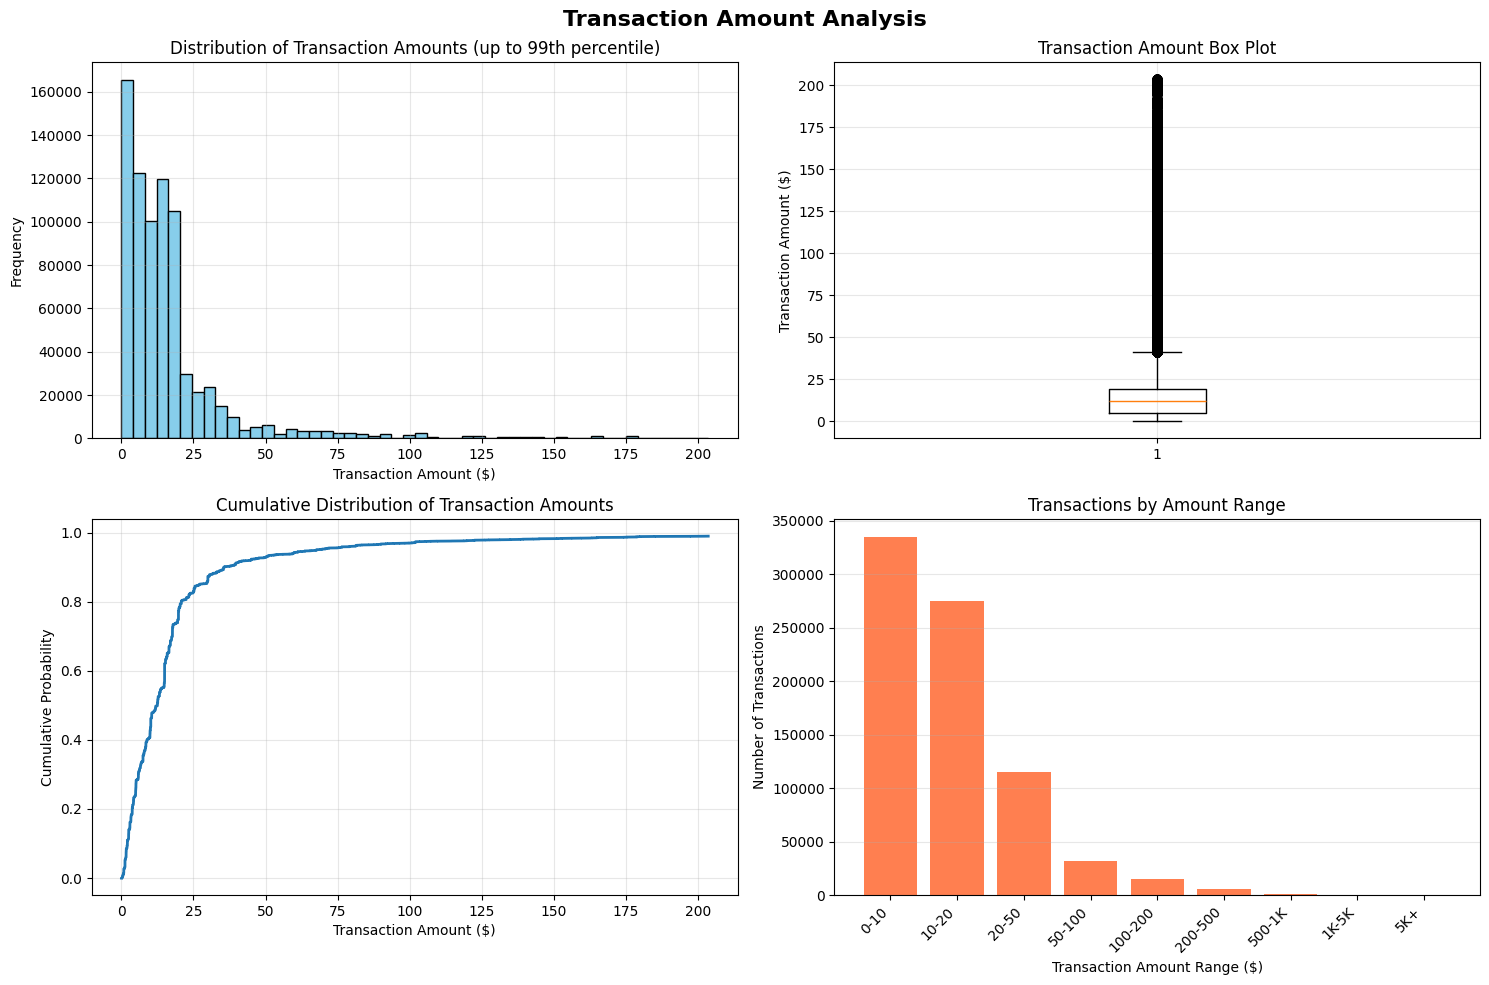


💡 Key Observations:
   - Most transactions are under $203.52 (99th percentile)
   - Median transaction: $12.48
   - Mean transaction: $22.29
   - The mean is higher than median, showing some high-value transactions pull the average up


In [59]:
# Let's look at the distribution of transaction amounts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Transaction Amount Analysis', fontsize=16, fontweight='bold')

# Plot 1: Histogram of transaction amounts
# Filter out extreme outliers for better visualization
transaction_amounts = df['TotalAmount']
q99 = transaction_amounts.quantile(0.99)

axes[0, 0].hist(transaction_amounts[transaction_amounts <= q99], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Transaction Amounts (up to 99th percentile)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Box plot of transaction amounts
axes[0, 1].boxplot(transaction_amounts[transaction_amounts <= q99], vert=True)
axes[0, 1].set_ylabel('Transaction Amount ($)')
axes[0, 1].set_title('Transaction Amount Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Cumulative distribution
sorted_amounts = np.sort(transaction_amounts)
cumulative = np.arange(1, len(sorted_amounts) + 1) / len(sorted_amounts)
axes[1, 0].plot(sorted_amounts[sorted_amounts <= q99], cumulative[sorted_amounts <= q99], linewidth=2)
axes[1, 0].set_xlabel('Transaction Amount ($)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution of Transaction Amounts')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Top 10 value ranges
# Create value bins
bins = [0, 10, 20, 50, 100, 200, 500, 1000, 5000, float('inf')]
labels = ['0-10', '10-20', '20-50', '50-100', '100-200', '200-500', '500-1K', '1K-5K', '5K+']
df['Amount_Range'] = pd.cut(df['TotalAmount'], bins=bins, labels=labels)
range_counts = df['Amount_Range'].value_counts().sort_index()

axes[1, 1].bar(range(len(range_counts)), range_counts.values, color='coral')
axes[1, 1].set_xticks(range(len(range_counts)))
axes[1, 1].set_xticklabels(range_counts.index, rotation=45, ha='right')
axes[1, 1].set_xlabel('Transaction Amount Range ($)')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_title('Transactions by Amount Range')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print(f"   - Most transactions are under ${q99:.2f} (99th percentile)")
print(f"   - Median transaction: ${transaction_amounts.median():.2f}")
print(f"   - Mean transaction: ${transaction_amounts.mean():.2f}")
print(f"   - The mean is higher than median, showing some high-value transactions pull the average up")

### 4.3: Time Series Analysis


📅 TIME SERIES ANALYSIS
--------------------------------------------------------------------------------


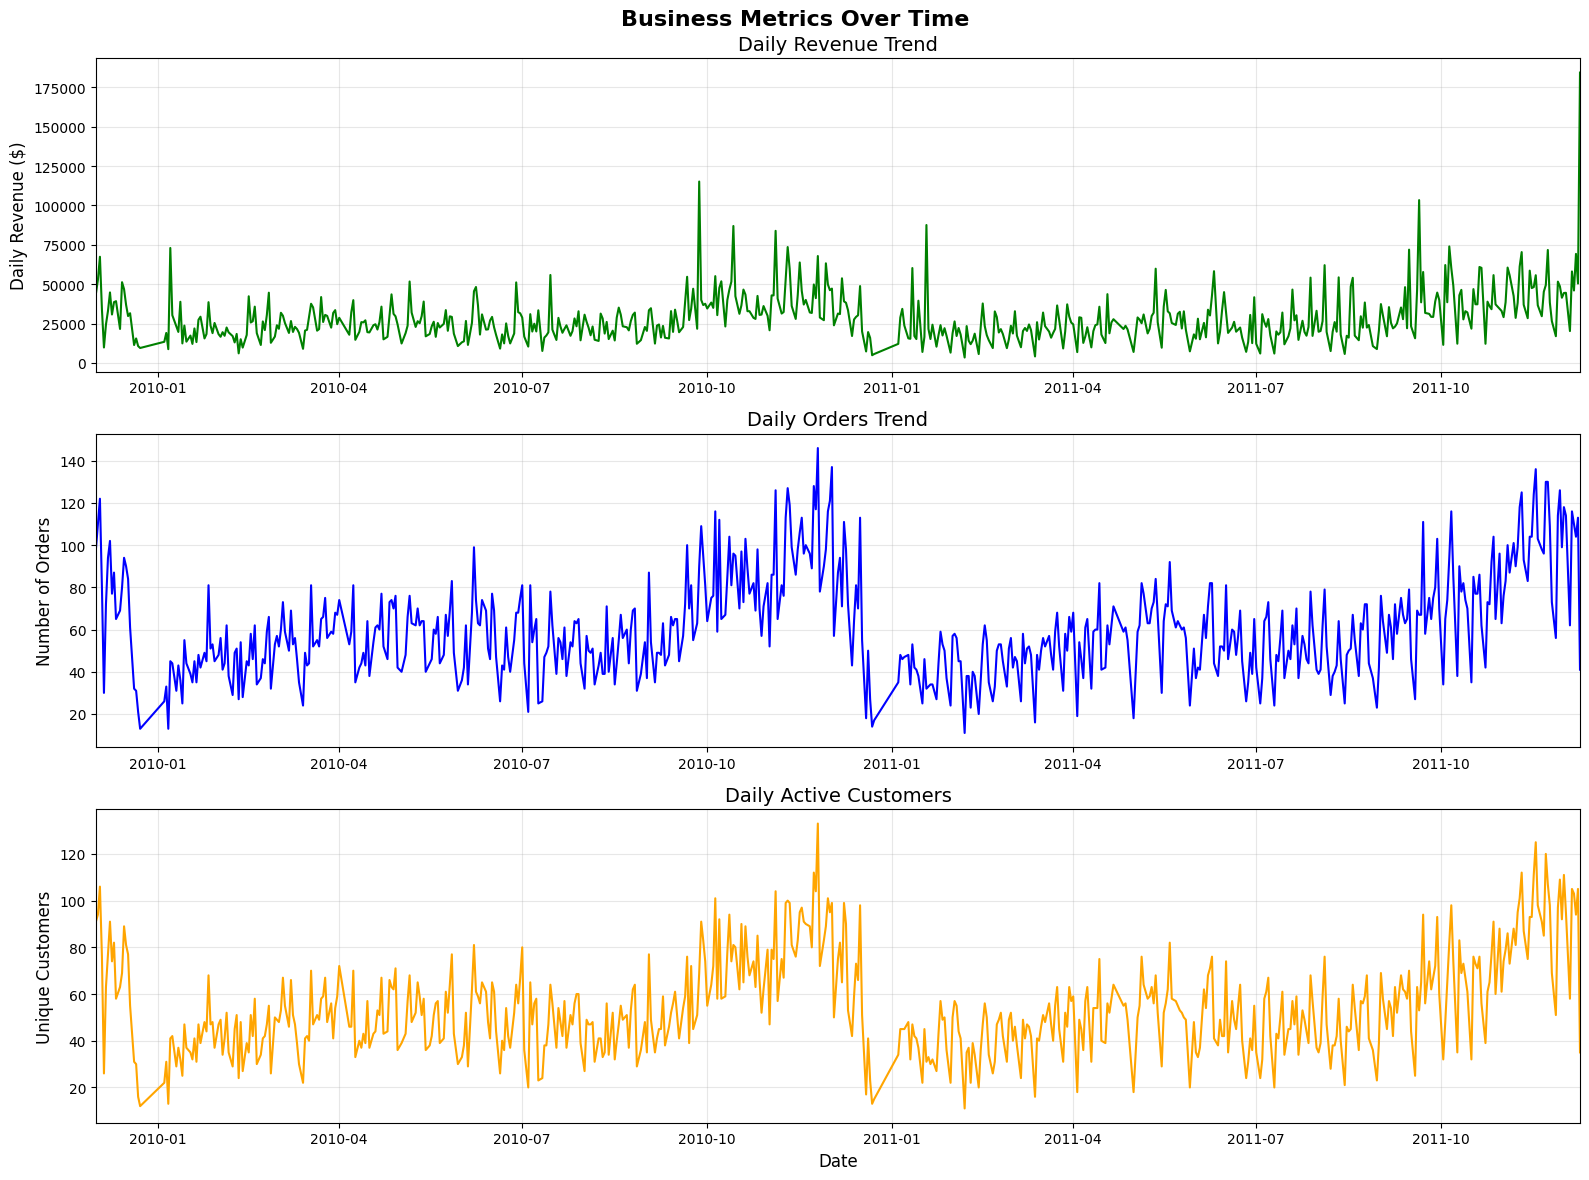


📊 Monthly Trends:
  Month  Num_Orders     Revenue  Unique_Customers
2009-12        1512  683504.010               955
2010-01        1011  555802.672               720
2010-02        1104  504558.956               772
2010-03        1524  696978.471              1057
2010-04        1329  591982.002               942
2010-05        1377  597833.380               966
2010-06        1497  636371.130              1041
2010-07        1381  589736.170               928
2010-08        1293  602224.600               911
2010-09        1689  829013.951              1145
2010-10        2133 1033112.010              1497
2010-11        2587 1166460.022              1607
2010-12        1400  570422.730               885
2011-01         987  568101.310               741
2011-02         997  446084.920               758
2011-03        1321  594081.760               974
2011-04        1149  468374.331               856
2011-05        1555  677355.150              1056
2011-06        1393  660046.050

In [60]:
# Analyze how transactions and revenue change over time
print("\n📅 TIME SERIES ANALYSIS")
print("-"*80)

# Aggregate by date
daily_stats = df.groupby(df['InvoiceDate'].dt.date).agg({
    'Invoice': 'nunique',
    'TotalAmount': 'sum',
    'Customer ID': 'nunique'
}).reset_index()
daily_stats.columns = ['Date', 'Num_Orders', 'Revenue', 'Unique_Customers']
daily_stats['Date'] = pd.to_datetime(daily_stats['Date'])

# Create time series plots
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Business Metrics Over Time', fontsize=16, fontweight='bold')

# Plot 1: Daily Revenue
axes[0].plot(daily_stats['Date'], daily_stats['Revenue'], linewidth=1.5, color='green')
axes[0].set_ylabel('Daily Revenue ($)', fontsize=12)
axes[0].set_title('Daily Revenue Trend', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(daily_stats['Date'].min(), daily_stats['Date'].max())

# Plot 2: Daily Orders
axes[1].plot(daily_stats['Date'], daily_stats['Num_Orders'], linewidth=1.5, color='blue')
axes[1].set_ylabel('Number of Orders', fontsize=12)
axes[1].set_title('Daily Orders Trend', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(daily_stats['Date'].min(), daily_stats['Date'].max())

# Plot 3: Daily Active Customers
axes[2].plot(daily_stats['Date'], daily_stats['Unique_Customers'], linewidth=1.5, color='orange')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Unique Customers', fontsize=12)
axes[2].set_title('Daily Active Customers', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(daily_stats['Date'].min(), daily_stats['Date'].max())

plt.tight_layout()
plt.show()

# Monthly aggregation for clearer trends
monthly_stats = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({
    'Invoice': 'nunique',
    'TotalAmount': 'sum',
    'Customer ID': 'nunique'
}).reset_index()
monthly_stats.columns = ['Month', 'Num_Orders', 'Revenue', 'Unique_Customers']

print("\n📊 Monthly Trends:")
print(monthly_stats.to_string(index=False))

print("\n💡 Key Observations:")
print(f"   - Average daily revenue: ${daily_stats['Revenue'].mean():,.2f}")
print(f"   - Peak daily revenue: ${daily_stats['Revenue'].max():,.2f}")
print(f"   - Average daily orders: {daily_stats['Num_Orders'].mean():.0f}")
print(f"   - Average daily active customers: {daily_stats['Unique_Customers'].mean():.0f}")

### 4.4: Customer Behavior Analysis


👥 CUSTOMER BEHAVIOR ANALYSIS
--------------------------------------------------------------------------------


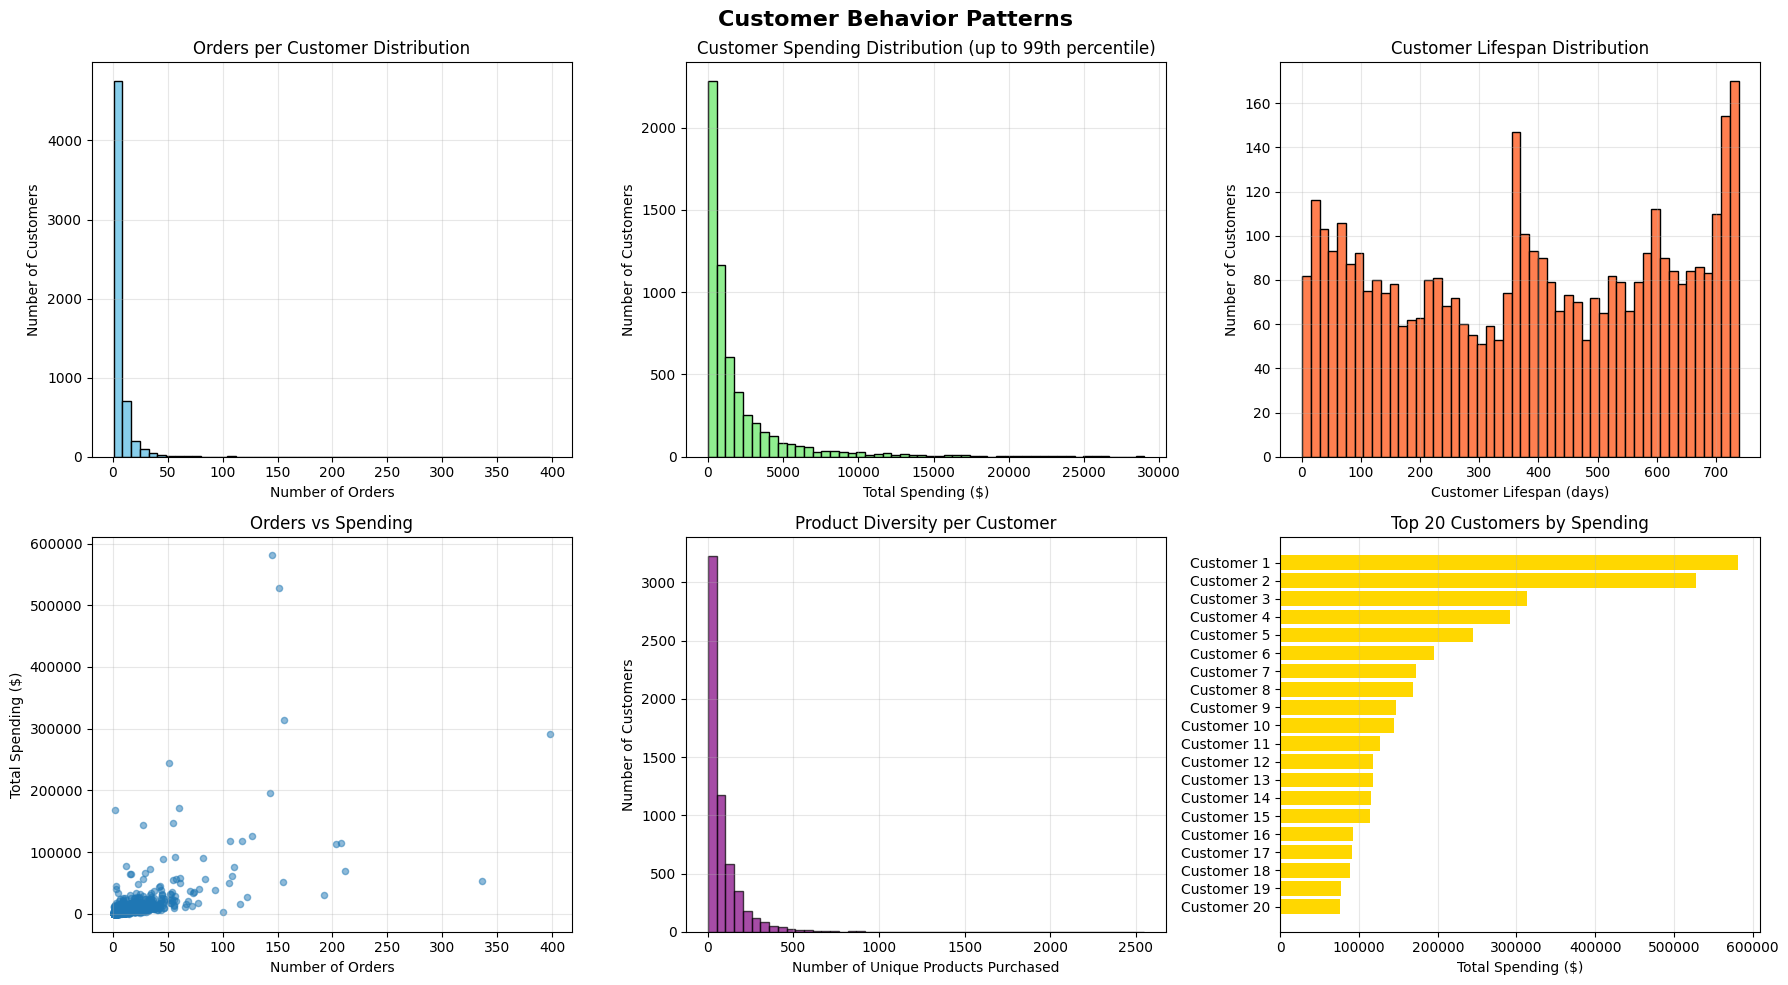


📈 Customer Statistics:
   Average orders per customer: 6.3
   Median orders per customer: 3.0
   Average spending per customer: $2955.90
   Median spending per customer: $867.74
   Average customer lifespan: 273 days
   Average unique products per customer: 82.0

🎯 Quick Customer Segments:
   One-time buyers: 1,623 (27.6%)
   Repeat customers: 4,255 (72.4%)
   Loyal customers (10+ orders): 974 (16.6%)
   VIP customers (top 5% spending): 294 (5.0%)


In [61]:
print("\n👥 CUSTOMER BEHAVIOR ANALYSIS")
print("-"*80)

# Calculate customer-level statistics
customer_stats = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'TotalAmount': 'sum',
    'InvoiceDate': ['min', 'max'],
    'StockCode': 'nunique'
}).reset_index()

customer_stats.columns = ['Customer_ID', 'Num_Orders', 'Total_Spent', 'First_Purchase', 'Last_Purchase', 'Unique_Products']
customer_stats['Customer_Lifespan_Days'] = (customer_stats['Last_Purchase'] - customer_stats['First_Purchase']).dt.days

# Create customer behavior visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Customer Behavior Patterns', fontsize=16, fontweight='bold')

# Plot 1: Distribution of orders per customer
axes[0, 0].hist(customer_stats['Num_Orders'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Orders per Customer Distribution')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution of total spending per customer
spending_99 = customer_stats['Total_Spent'].quantile(0.99)
axes[0, 1].hist(customer_stats[customer_stats['Total_Spent'] <= spending_99]['Total_Spent'],
                bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Total Spending ($)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Customer Spending Distribution (up to 99th percentile)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Customer lifespan distribution
axes[0, 2].hist(customer_stats[customer_stats['Customer_Lifespan_Days'] > 0]['Customer_Lifespan_Days'],
                bins=50, color='coral', edgecolor='black')
axes[0, 2].set_xlabel('Customer Lifespan (days)')
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].set_title('Customer Lifespan Distribution')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Orders vs Spending scatter
axes[1, 0].scatter(customer_stats['Num_Orders'], customer_stats['Total_Spent'], alpha=0.5, s=20)
axes[1, 0].set_xlabel('Number of Orders')
axes[1, 0].set_ylabel('Total Spending ($)')
axes[1, 0].set_title('Orders vs Spending')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Product diversity per customer
axes[1, 1].hist(customer_stats['Unique_Products'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Unique Products Purchased')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].set_title('Product Diversity per Customer')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Top 20 customers by spending
top_20 = customer_stats.nlargest(20, 'Total_Spent')
axes[1, 2].barh(range(20), top_20['Total_Spent'].values, color='gold')
axes[1, 2].set_yticks(range(20))
axes[1, 2].set_yticklabels([f'Customer {i+1}' for i in range(20)])
axes[1, 2].set_xlabel('Total Spending ($)')
axes[1, 2].set_title('Top 20 Customers by Spending')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📈 Customer Statistics:")
print(f"   Average orders per customer: {customer_stats['Num_Orders'].mean():.1f}")
print(f"   Median orders per customer: {customer_stats['Num_Orders'].median():.1f}")
print(f"   Average spending per customer: ${customer_stats['Total_Spent'].mean():.2f}")
print(f"   Median spending per customer: ${customer_stats['Total_Spent'].median():.2f}")
print(f"   Average customer lifespan: {customer_stats['Customer_Lifespan_Days'].mean():.0f} days")
print(f"   Average unique products per customer: {customer_stats['Unique_Products'].mean():.1f}")

# Customer segmentation preview
print("\n🎯 Quick Customer Segments:")
one_time = (customer_stats['Num_Orders'] == 1).sum()
repeat = (customer_stats['Num_Orders'] > 1).sum()
loyal = (customer_stats['Num_Orders'] >= 10).sum()
vip = (customer_stats['Total_Spent'] >= customer_stats['Total_Spent'].quantile(0.95)).sum()

print(f"   One-time buyers: {one_time:,} ({one_time/len(customer_stats)*100:.1f}%)")
print(f"   Repeat customers: {repeat:,} ({repeat/len(customer_stats)*100:.1f}%)")
print(f"   Loyal customers (10+ orders): {loyal:,} ({loyal/len(customer_stats)*100:.1f}%)")
print(f"   VIP customers (top 5% spending): {vip:,} ({vip/len(customer_stats)*100:.1f}%)")

### 4.5: Product Analysis


🛍️  PRODUCT ANALYSIS
--------------------------------------------------------------------------------


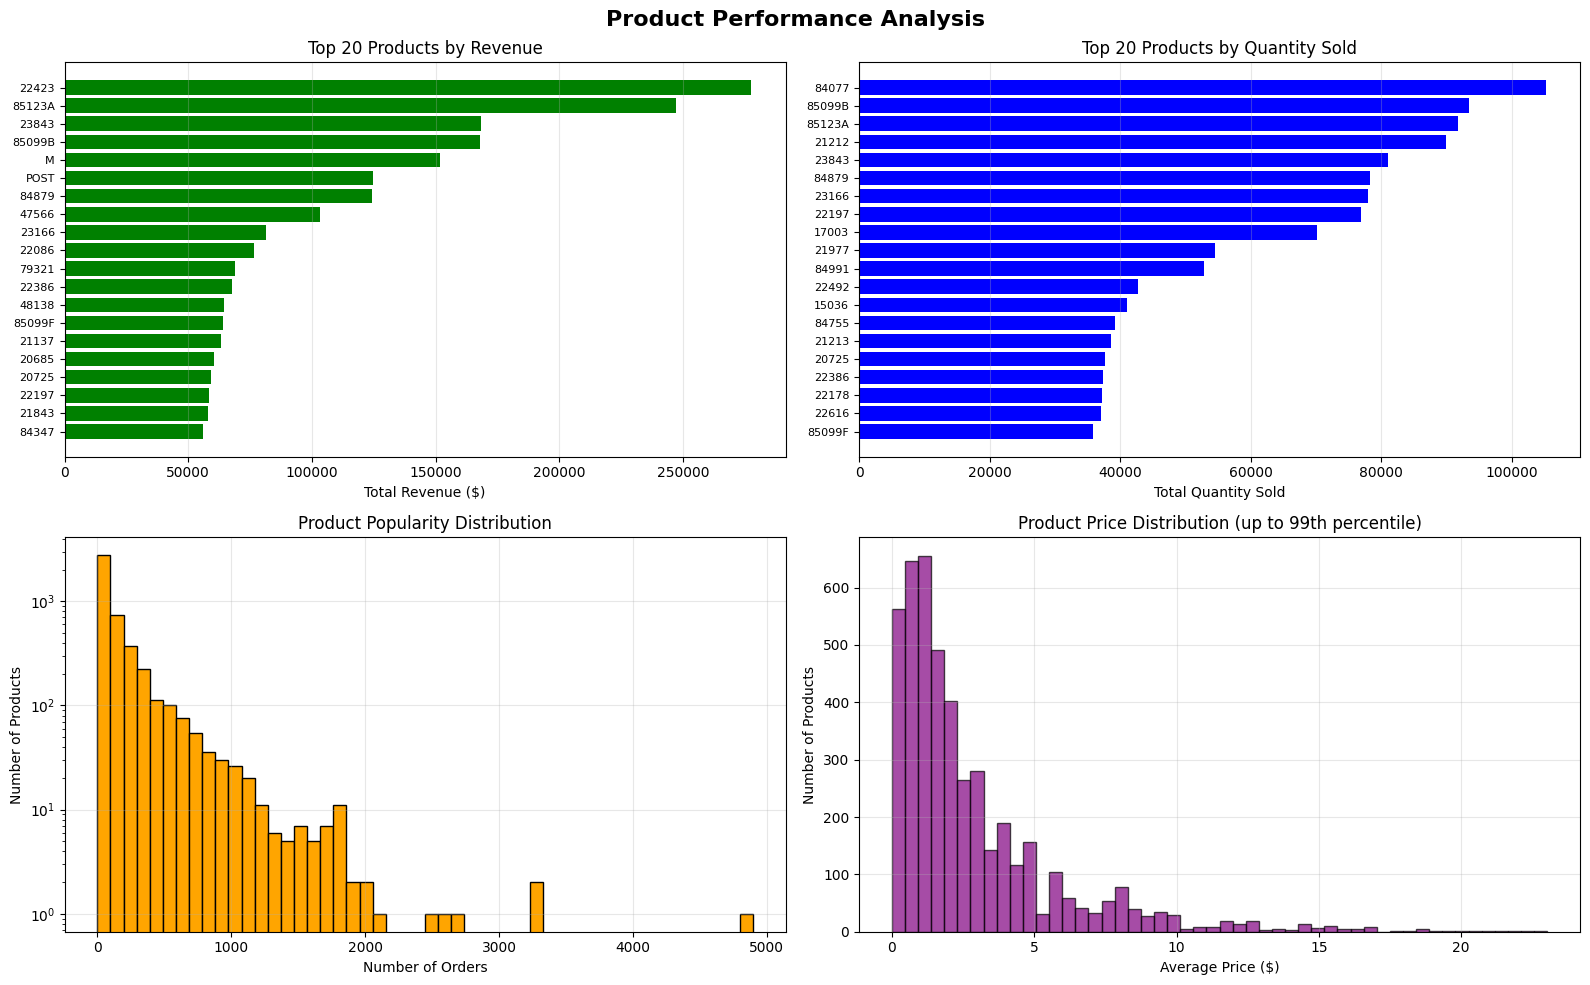


📊 Product Statistics:
   Total unique products: 4,631
   Average orders per product: 166.0
   Median orders per product: 65.0
   Average price: $3.60
   Median price: $1.79

🏆 Top 10 Products by Revenue:
   22423: REGENCY CAKESTAND 3 TIER
      Revenue: $277,656.25, Quantity: 24,124
   85123A: WHITE HANGING HEART T-LIGHT HOLDER
      Revenue: $247,203.36, Quantity: 91,814
   23843: PAPER CRAFT , LITTLE BIRDIE
      Revenue: $168,469.60, Quantity: 80,995
   85099B: JUMBO BAG RED WHITE SPOTTY 
      Revenue: $167,920.64, Quantity: 93,436
   M: Manual
      Revenue: $151,777.67, Quantity: 9,384
   POST: POSTAGE
      Revenue: $124,648.04, Quantity: 5,235
   84879: ASSORTED COLOUR BIRD ORNAMENT
      Revenue: $124,351.86, Quantity: 78,234
   47566: PARTY BUNTING
      Revenue: $103,283.38, Quantity: 23,460
   23166: MEDIUM CERAMIC TOP STORAGE JAR
      Revenue: $81,416.73, Quantity: 77,916
   22086: PAPER CHAIN KIT 50'S CHRISTMAS 
      Revenue: $76,598.18, Quantity: 28,380


In [62]:
print("\n🛍️  PRODUCT ANALYSIS")
print("-"*80)

# Product-level statistics
product_stats = df.groupby('StockCode').agg({
    'Quantity': 'sum',
    'TotalAmount': 'sum',
    'Invoice': 'nunique',
    'Customer ID': 'nunique',
    'Description': 'first'
}).reset_index()

product_stats.columns = ['StockCode', 'Total_Quantity_Sold', 'Total_Revenue', 'Num_Orders', 'Num_Customers', 'Description']
product_stats['Avg_Price'] = product_stats['Total_Revenue'] / product_stats['Total_Quantity_Sold']

# Create product visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Product Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top 20 products by revenue
top_revenue = product_stats.nlargest(20, 'Total_Revenue')
axes[0, 0].barh(range(20), top_revenue['Total_Revenue'].values, color='green')
axes[0, 0].set_yticks(range(20))
axes[0, 0].set_yticklabels([f'{code[:10]}...' if len(str(code)) > 10 else code
                             for code in top_revenue['StockCode'].values], fontsize=8)
axes[0, 0].set_xlabel('Total Revenue ($)')
axes[0, 0].set_title('Top 20 Products by Revenue')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: Top 20 products by quantity sold
top_quantity = product_stats.nlargest(20, 'Total_Quantity_Sold')
axes[0, 1].barh(range(20), top_quantity['Total_Quantity_Sold'].values, color='blue')
axes[0, 1].set_yticks(range(20))
axes[0, 1].set_yticklabels([f'{code[:10]}...' if len(str(code)) > 10 else code
                             for code in top_quantity['StockCode'].values], fontsize=8)
axes[0, 1].set_xlabel('Total Quantity Sold')
axes[0, 1].set_title('Top 20 Products by Quantity Sold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Product popularity distribution
axes[1, 0].hist(product_stats['Num_Orders'], bins=50, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('Number of Orders')
axes[1, 0].set_ylabel('Number of Products')
axes[1, 0].set_title('Product Popularity Distribution')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Price distribution
price_99 = product_stats['Avg_Price'].quantile(0.99)
axes[1, 1].hist(product_stats[product_stats['Avg_Price'] <= price_99]['Avg_Price'],
                bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Price ($)')
axes[1, 1].set_ylabel('Number of Products')
axes[1, 1].set_title('Product Price Distribution (up to 99th percentile)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Product Statistics:")
print(f"   Total unique products: {len(product_stats):,}")
print(f"   Average orders per product: {product_stats['Num_Orders'].mean():.1f}")
print(f"   Median orders per product: {product_stats['Num_Orders'].median():.1f}")
print(f"   Average price: ${product_stats['Avg_Price'].mean():.2f}")
print(f"   Median price: ${product_stats['Avg_Price'].median():.2f}")

print("\n🏆 Top 10 Products by Revenue:")
top_10_products = product_stats.nlargest(10, 'Total_Revenue')[['StockCode', 'Description', 'Total_Revenue', 'Total_Quantity_Sold']]
for idx, row in top_10_products.iterrows():
    desc = row['Description'] if pd.notna(row['Description']) else 'N/A'
    desc_short = desc[:40] + '...' if len(str(desc)) > 40 else desc
    print(f"   {row['StockCode']}: {desc_short}")
    print(f"      Revenue: ${row['Total_Revenue']:,.2f}, Quantity: {row['Total_Quantity_Sold']:,}")

### 4.6: Geographic Analysis


🌍 GEOGRAPHIC ANALYSIS
--------------------------------------------------------------------------------


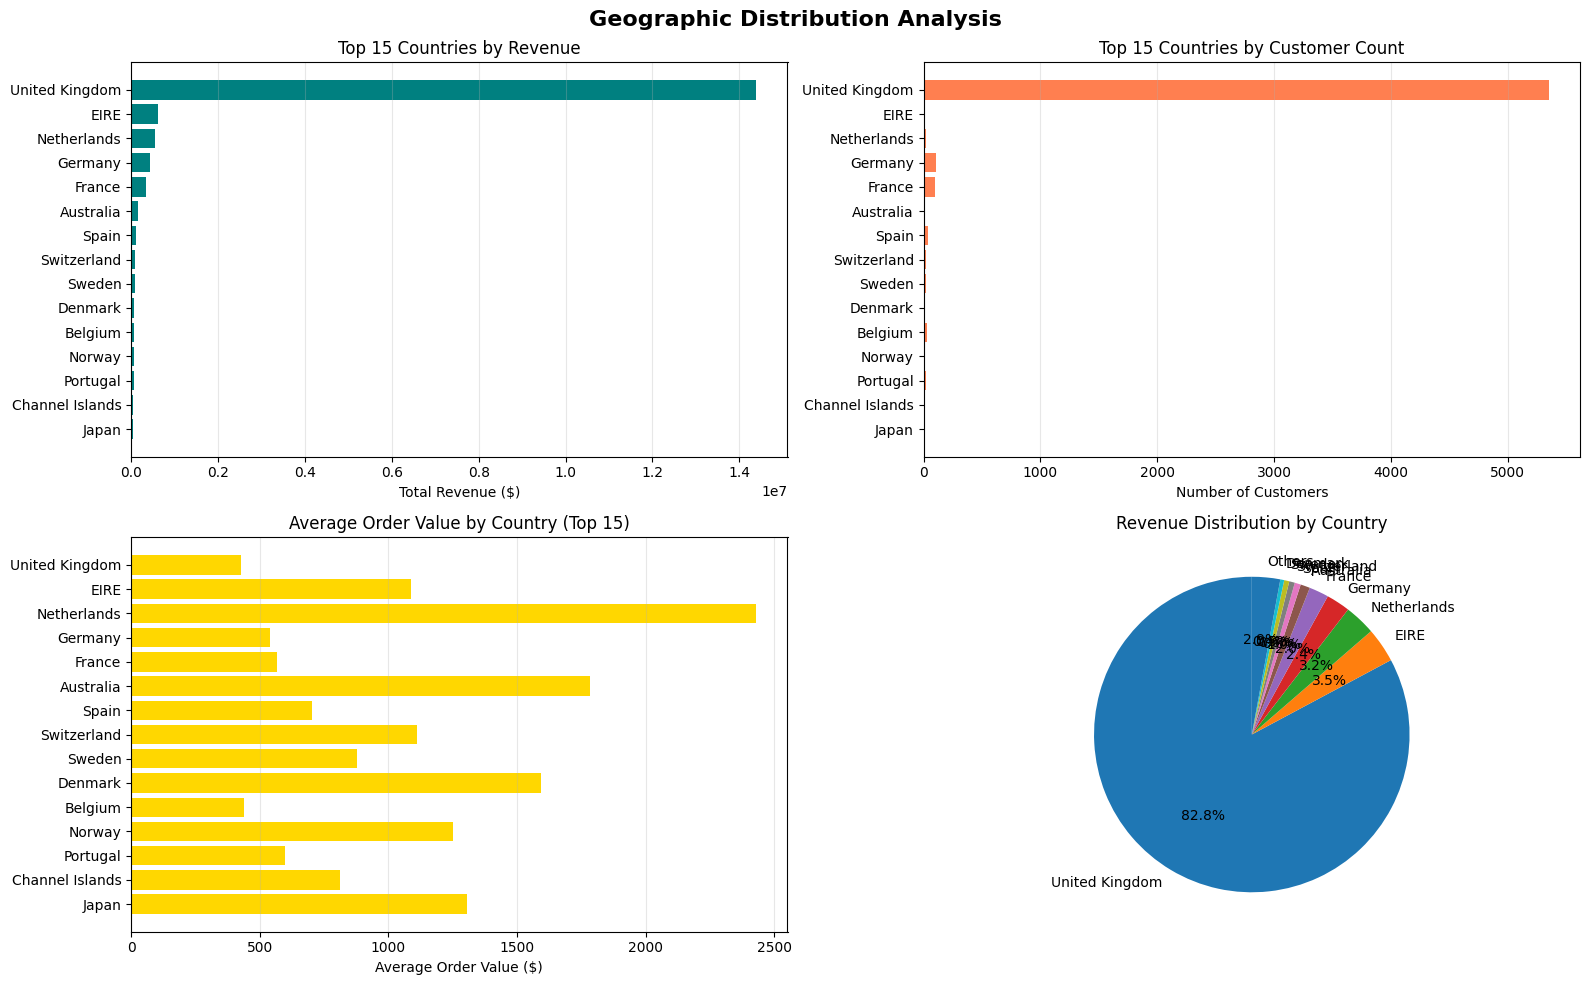


🌎 Geographic Statistics:
   Total countries: 41
   Top country: United Kingdom ($14,389,234.92)
   Top 3 countries account for: 89.6% of revenue

🏅 Top 10 Countries Summary:
       Country  Num_Orders  Total_Revenue  Num_Customers  Avg_Order_Value
United Kingdom       33541   14389234.917           5350       429.004350
          EIRE         567     616570.540              5      1087.425996
   Netherlands         228     554038.090             22      2429.991623
       Germany         789     425019.711            107       538.681510
        France         614     348768.960             95       568.027622
     Australia          95     169283.460             15      1781.931158
         Spain         154     108332.490             41       703.457727
   Switzerland          90     100061.940             22      1111.799333
        Sweden         104      91515.820             19       879.959808
       Denmark          43      68580.690             12      1594.899767


In [63]:
print("\n🌍 GEOGRAPHIC ANALYSIS")
print("-"*80)

# Country-level statistics
country_stats = df.groupby('Country').agg({
    'Invoice': 'nunique',
    'TotalAmount': 'sum',
    'Customer ID': 'nunique'
}).reset_index()

country_stats.columns = ['Country', 'Num_Orders', 'Total_Revenue', 'Num_Customers']
country_stats['Avg_Order_Value'] = country_stats['Total_Revenue'] / country_stats['Num_Orders']
country_stats = country_stats.sort_values('Total_Revenue', ascending=False)

# Create geographic visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Geographic Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top 15 countries by revenue
top_15_countries = country_stats.head(15)
axes[0, 0].barh(range(15), top_15_countries['Total_Revenue'].values, color='teal')
axes[0, 0].set_yticks(range(15))
axes[0, 0].set_yticklabels(top_15_countries['Country'].values)
axes[0, 0].set_xlabel('Total Revenue ($)')
axes[0, 0].set_title('Top 15 Countries by Revenue')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: Top 15 countries by number of customers
axes[0, 1].barh(range(15), top_15_countries['Num_Customers'].values, color='coral')
axes[0, 1].set_yticks(range(15))
axes[0, 1].set_yticklabels(top_15_countries['Country'].values)
axes[0, 1].set_xlabel('Number of Customers')
axes[0, 1].set_title('Top 15 Countries by Customer Count')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Average order value by country (top 15)
axes[1, 0].barh(range(15), top_15_countries['Avg_Order_Value'].values, color='gold')
axes[1, 0].set_yticks(range(15))
axes[1, 0].set_yticklabels(top_15_countries['Country'].values)
axes[1, 0].set_xlabel('Average Order Value ($)')
axes[1, 0].set_title('Average Order Value by Country (Top 15)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Revenue distribution pie chart (top 10 + others)
top_10_revenue = country_stats.head(10)
others_revenue = country_stats.iloc[10:]['Total_Revenue'].sum()

pie_data = list(top_10_revenue['Total_Revenue'].values) + [others_revenue]
pie_labels = list(top_10_revenue['Country'].values) + ['Others']

axes[1, 1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Revenue Distribution by Country')

plt.tight_layout()
plt.show()

print("\n🌎 Geographic Statistics:")
print(f"   Total countries: {len(country_stats)}")
print(f"   Top country: {country_stats.iloc[0]['Country']} (${country_stats.iloc[0]['Total_Revenue']:,.2f})")
print(f"   Top 3 countries account for: {country_stats.head(3)['Total_Revenue'].sum()/country_stats['Total_Revenue'].sum()*100:.1f}% of revenue")

print("\n🏅 Top 10 Countries Summary:")
print(country_stats.head(10).to_string(index=False))

### 4.7: Key Correlations and Relationships


🔗 CORRELATION ANALYSIS
--------------------------------------------------------------------------------


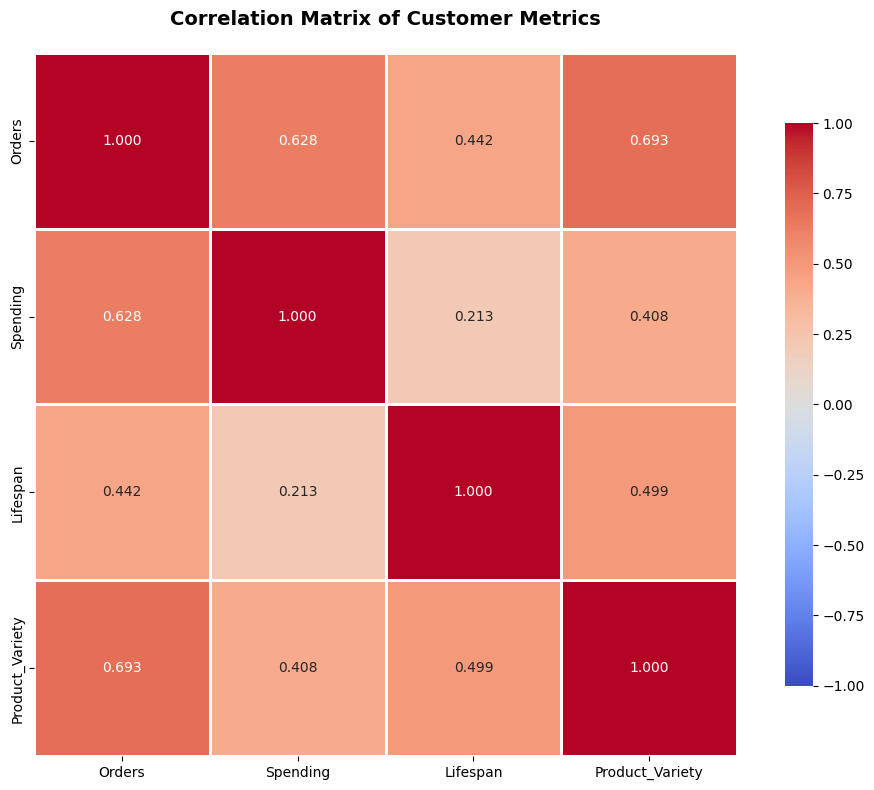


🔍 Key Correlations:
   Orders ↔ Spending: 0.628
   Orders ↔ Lifespan: 0.442
   Orders ↔ Product Variety: 0.693
   Spending ↔ Product Variety: 0.408

💡 Insights:
   - Customers who order more frequently also buy more variety
   - Product variety might be a good retention indicator


In [64]:
print("\n🔗 CORRELATION ANALYSIS")
print("-"*80)

# Create a correlation matrix of key customer metrics
correlation_data = customer_stats[[
    'Num_Orders',
    'Total_Spent',
    'Customer_Lifespan_Days',
    'Unique_Products'
]].copy()

correlation_data.columns = ['Orders', 'Spending', 'Lifespan', 'Product_Variety']

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Customer Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n🔍 Key Correlations:")
print(f"   Orders ↔ Spending: {corr_matrix.loc['Orders', 'Spending']:.3f}")
print(f"   Orders ↔ Lifespan: {corr_matrix.loc['Orders', 'Lifespan']:.3f}")
print(f"   Orders ↔ Product Variety: {corr_matrix.loc['Orders', 'Product_Variety']:.3f}")
print(f"   Spending ↔ Product Variety: {corr_matrix.loc['Spending', 'Product_Variety']:.3f}")

print("\n💡 Insights:")
if corr_matrix.loc['Orders', 'Spending'] > 0.8:
    print("   - Strong correlation between number of orders and total spending")
    print("   - More orders = More revenue (pretty obvious, but good to confirm!)")
if corr_matrix.loc['Orders', 'Product_Variety'] > 0.5:
    print("   - Customers who order more frequently also buy more variety")
    print("   - Product variety might be a good retention indicator")
if corr_matrix.loc['Orders', 'Lifespan'] > 0.5:
    print("   - Longer customer relationships correlate with more orders")
    print("   - Keeping customers engaged over time is valuable")

### 4.8: EDA Summary and Key Insights

In [65]:
print("\n" + "="*80)
print("📋 EDA SUMMARY: KEY INSIGHTS FOR MODELING")
print("="*80)

print("\n1️⃣  DATA QUALITY & SCOPE")
print(f"   ✓ Clean dataset with {len(df):,} transactions")
print(f"   ✓ {df['Customer ID'].nunique():,} unique customers over {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days:,} days")
print(f"   ✓ Data spans from {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

print("\n2️⃣  CUSTOMER BEHAVIOR PATTERNS")
one_time_pct = (customer_stats['Num_Orders'] == 1).sum() / len(customer_stats) * 100
repeat_pct = (customer_stats['Num_Orders'] > 1).sum() / len(customer_stats) * 100
print(f"   ✓ {one_time_pct:.1f}% are one-time buyers (potential churn risk!)")
print(f"   ✓ {repeat_pct:.1f}% are repeat customers (these are valuable!)")
print(f"   ✓ Average customer makes {customer_stats['Num_Orders'].mean():.1f} orders")
print(f"   ✓ Average customer lifetime: {customer_stats['Customer_Lifespan_Days'].mean():.0f} days")

print("\n3️⃣  REVENUE INSIGHTS")
print(f"   ✓ Total revenue: ${df['TotalAmount'].sum():,.2f}")
print(f"   ✓ Average transaction: ${df['TotalAmount'].mean():.2f}")
print(f"   ✓ Top 5% of customers likely drive significant revenue (power law)")

print("\n4️⃣  TEMPORAL PATTERNS")
print(f"   ✓ Average daily orders: {daily_stats['Num_Orders'].mean():.0f}")
print(f"   ✓ Average daily revenue: ${daily_stats['Revenue'].mean():,.2f}")
print(f"   ✓ Business shows variability - some seasonality may exist")

print("\n5️⃣  GEOGRAPHIC CONCENTRATION")
top_country_pct = country_stats.iloc[0]['Total_Revenue'] / country_stats['Total_Revenue'].sum() * 100
print(f"   ✓ Business is concentrated in {country_stats.iloc[0]['Country']} ({top_country_pct:.1f}% of revenue)")
print(f"   ✓ Operates in {len(country_stats)} countries")

print("\n6️⃣  IMPLICATIONS FOR CHURN PREDICTION")
print("   ✓ High percentage of one-time buyers suggests churn is a real problem")
print("   ✓ Strong correlation between orders and spending validates using frequency features")
print("   ✓ Customer lifespan varies widely - recency will be important")
print("   ✓ Product variety correlation suggests it's a good engagement metric")

print("\n7️⃣  READY FOR MODELING")
print("   ✓ Data is clean and well-structured")
print("   ✓ Clear patterns exist that models can learn from")
print("   ✓ Business problem (churn) is validated by the data")
print("   ✓ Ready to proceed with temporal split and feature engineering")

print("\n" + "="*80)


📋 EDA SUMMARY: KEY INSIGHTS FOR MODELING

1️⃣  DATA QUALITY & SCOPE
   ✓ Clean dataset with 779,425 transactions
   ✓ 5,878 unique customers over 738 days
   ✓ Data spans from 2009-12-01 to 2011-12-09

2️⃣  CUSTOMER BEHAVIOR PATTERNS
   ✓ 27.6% are one-time buyers (potential churn risk!)
   ✓ 72.4% are repeat customers (these are valuable!)
   ✓ Average customer makes 6.3 orders
   ✓ Average customer lifetime: 273 days

3️⃣  REVENUE INSIGHTS
   ✓ Total revenue: $17,374,804.27
   ✓ Average transaction: $22.29
   ✓ Top 5% of customers likely drive significant revenue (power law)

4️⃣  TEMPORAL PATTERNS
   ✓ Average daily orders: 61
   ✓ Average daily revenue: $28,766.23
   ✓ Business shows variability - some seasonality may exist

5️⃣  GEOGRAPHIC CONCENTRATION
   ✓ Business is concentrated in United Kingdom (82.8% of revenue)
   ✓ Operates in 41 countries

6️⃣  IMPLICATIONS FOR CHURN PREDICTION
   ✓ High percentage of one-time buyers suggests churn is a real problem
   ✓ Strong correlat

---
## Section 5: Create Training and Test Sets

### Why This Matters

We need to split our data in a way that mimics real-world usage:
- Use older data to train the model
- Test on newer data to see how well we predict the future
- Make sure there's NO overlap between feature calculation and label determination

### How We Split

We work **backwards from the most recent date**:

```
Timeline:
[========= TRAINING =========][== GAP ==][========== TESTING ==========]
                                         
TRAINING:                                TESTING:
  [Features][Labels]                       [Features][Labels]
```

This ensures:
1. No data leakage (features come from BEFORE labels)
2. Realistic evaluation (predicting actual future churn)
3. Both sets have enough data to work with

In [66]:
print("="*80)
print("TEMPORAL TRAIN/TEST SPLIT")
print("="*80)

# Get the full date range of our data
start_date = df['InvoiceDate'].min()
end_date = df['InvoiceDate'].max()
total_days = (end_date - start_date).days

print(f"\nAvailable data:")
print(f"  Start: {start_date.date()}")
print(f"  End: {end_date.date()}")
print(f"  Duration: {total_days} days ({total_days/30:.1f} months)")

# Calculate how many days we need total
required_days = (
    config.TEST_FEATURE_WINDOW +  # Test set needs purchase history
    config.TEST_LABEL_WINDOW +     # Test set needs time to observe churn
    config.TRAIN_LABEL_WINDOW      # Training set needs time to observe churn
)

print(f"\nRequired days for optimal split: {required_days}")
print(f"  Test feature window: {config.TEST_FEATURE_WINDOW} days (3 months)")
print(f"  Test label window: {config.TEST_LABEL_WINDOW} days (3 months)")
print(f"  Train label window: {config.TRAIN_LABEL_WINDOW} days (3 months)")

# Make sure we have enough data
if total_days < required_days:
    raise ValueError(
        f"Not enough data! Have {total_days} days, need {required_days} days. "
        f"Need {required_days - total_days} more days of transaction history."
    )

print(f"\n✓ We have enough data ({total_days} >= {required_days})")

# Work backwards from the end date to define our split points
print(f"\nCalculating split points...")

# TEST SET WINDOWS
# Start from the most recent date and work backwards
test_label_end = end_date
test_label_start = test_label_end - timedelta(days=config.TEST_LABEL_WINDOW)
test_feature_end = test_label_start
test_feature_start = test_feature_end - timedelta(days=config.TEST_FEATURE_WINDOW)

# TRAINING SET WINDOWS
# Everything before the test set, with a gap to prevent overlap
train_end = test_feature_start - timedelta(days=1)  # 1 day gap
train_label_end = train_end  # The end of the training period
train_label_start = train_label_end - timedelta(days=config.TRAIN_LABEL_WINDOW)
train_feature_end = train_label_start
train_feature_start = start_date  # Use all available early data

# Calculate the gap between training and testing
gap_days = (test_feature_start - train_end).days

# Display the complete split configuration
print("\n" + "="*80)
print("SPLIT CONFIGURATION")
print("="*80)

print("\n📅 TRAINING SET:")
print(f"  Full period: {train_feature_start.date()} → {train_label_end.date()}")
print(f"  Duration: {(train_label_end - train_feature_start).days} days ({(train_label_end - train_feature_start).days/30:.1f} months)")
print(f"  ├─ Feature calculation: {train_feature_start.date()} → {train_feature_end.date()} ({(train_feature_end - train_feature_start).days} days)")
print(f"  └─ Churn labeling:      {train_label_start.date()} → {train_label_end.date()} ({(train_label_end - train_label_start).days} days)")

print("\n📅 TESTING SET:")
print(f"  Full period: {test_feature_start.date()} → {test_label_end.date()}")
print(f"  Duration: {(test_label_end - test_feature_start).days} days ({(test_label_end - test_feature_start).days/30:.1f} months)")
print(f"  ├─ Feature calculation: {test_feature_start.date()} → {test_feature_end.date()} ({(test_feature_end - test_feature_start).days} days)")
print(f"  └─ Churn labeling:      {test_label_start.date()} → {test_label_end.date()} ({(test_label_end - test_label_start).days} days)")

print(f"\n⏳ Temporal gap between train and test: {gap_days} day(s)")
print("   (This prevents any data leakage)")

TEMPORAL TRAIN/TEST SPLIT

Available data:
  Start: 2009-12-01
  End: 2011-12-09
  Duration: 738 days (24.6 months)

Required days for optimal split: 270
  Test feature window: 90 days (3 months)
  Test label window: 90 days (3 months)
  Train label window: 90 days (3 months)

✓ We have enough data (738 >= 270)

Calculating split points...

SPLIT CONFIGURATION

📅 TRAINING SET:
  Full period: 2009-12-01 → 2011-06-11
  Duration: 557 days (18.6 months)
  ├─ Feature calculation: 2009-12-01 → 2011-03-13 (467 days)
  └─ Churn labeling:      2011-03-13 → 2011-06-11 (90 days)

📅 TESTING SET:
  Full period: 2011-06-12 → 2011-12-09
  Duration: 180 days (6.0 months)
  ├─ Feature calculation: 2011-06-12 → 2011-09-10 (90 days)
  └─ Churn labeling:      2011-09-10 → 2011-12-09 (90 days)

⏳ Temporal gap between train and test: 1 day(s)
   (This prevents any data leakage)


In [67]:
# Actually create the training and test datasets
print("\n" + "="*80)
print("CREATING TRAIN AND TEST DATASETS")
print("="*80)

# Training set: all transactions up to train_end
df_train = df[df['InvoiceDate'] <= train_end].copy()

# Testing set: transactions from test_feature_start onwards
df_test = df[df['InvoiceDate'] >= test_feature_start].copy()

# Double-check there's no overlap in the raw data
# (There shouldn't be any since we have a time gap)
overlap = len(df_train.merge(df_test, on=df.columns.tolist(), how='inner'))
assert overlap == 0, f"ERROR: Found {overlap} overlapping transactions!"

# Calculate statistics
train_customers = df_train['Customer ID'].nunique()
test_customers = df_test['Customer ID'].nunique()

# Some customers might appear in both periods (that's OK and expected)
customer_overlap = len(
    set(df_train['Customer ID'].unique()) &
    set(df_test['Customer ID'].unique())
)

print(f"\nTraining Set:")
print(f"  Transactions: {len(df_train):,}")
print(f"  Customers: {train_customers:,}")
print(f"  Date range: {df_train['InvoiceDate'].min().date()} → {df_train['InvoiceDate'].max().date()}")

print(f"\nTesting Set:")
print(f"  Transactions: {len(df_test):,}")
print(f"  Customers: {test_customers:,}")
print(f"  Date range: {df_test['InvoiceDate'].min().date()} → {df_test['InvoiceDate'].max().date()}")

print(f"\nCustomer Overlap: {customer_overlap:,} customers ({customer_overlap/train_customers*100:.1f}% of training customers)")
print(f"  Note: It's normal for customers to appear in both periods.")
print(f"        What matters is the TEMPORAL separation (no transaction overlap).")

# Validate the split quality
print("\n✓ Checking split quality...")

warnings_found = []

if test_customers < config.MIN_CUSTOMERS_TEST:
    warnings_found.append(
        f"Test set has only {test_customers:,} customers (recommended: {config.MIN_CUSTOMERS_TEST:,}+)"
    )

if len(df_test) < config.MIN_TRANSACTIONS_TEST:
    warnings_found.append(
        f"Test set has only {len(df_test):,} transactions (recommended: {config.MIN_TRANSACTIONS_TEST:,}+)"
    )

if (test_feature_end - test_feature_start).days < 90:
    warnings_found.append(
        f"Test feature window is only {(test_feature_end - test_feature_start).days} days (recommended: 90+ days)"
    )

if warnings_found:
    print("\n⚠️  Warnings:")
    for warning in warnings_found:
        print(f"  • {warning}")
    print("\n  The split will work, but performance might be affected.")
else:
    print("\n✅ Split quality is excellent!")

# Summary statistics
total_customers = df['Customer ID'].nunique()
train_pct = (train_customers / total_customers) * 100
test_pct = (test_customers / total_customers) * 100

print(f"\nSplit ratio:")
print(f"  Training: {len(df_train)/len(df)*100:.1f}% of transactions")
print(f"  Testing:  {len(df_test)/len(df)*100:.1f}% of transactions")


CREATING TRAIN AND TEST DATASETS

Training Set:
  Transactions: 540,351
  Customers: 4,976
  Date range: 2009-12-01 → 2011-06-10

Testing Set:
  Transactions: 238,672
  Customers: 3,478
  Date range: 2011-06-12 → 2011-12-09

Customer Overlap: 2,576 customers (51.8% of training customers)
  Note: It's normal for customers to appear in both periods.
        What matters is the TEMPORAL separation (no transaction overlap).

✓ Checking split quality...

✅ Split quality is excellent!

Split ratio:
  Training: 69.3% of transactions
  Testing:  30.6% of transactions


---
## Section 6: Feature Engineering

### What We're Doing Here

We need to convert raw transaction data into customer-level features that capture purchase behavior. For each customer, we calculate:

**Time-based features:**
- How long ago was their last purchase?
- How long have they been a customer?
- What's their purchase span?

**Frequency features:**
- How often do they buy?
- How many days between purchases on average?

**Monetary features:**
- Total spending
- Average transaction amount
- Spending consistency

**Product features:**
- How many different products do they buy?
- How many items per transaction?

### The Critical Part: Labels

We determine if a customer churned by checking if they made ANY purchase in the label window.
- If yes → Churned = 0 (still active)
- If no → Churned = 1 (they left us)

In [68]:
def create_features_and_labels(df, feature_end_date, label_end_date, dataset_name="Dataset"):
    """
    Convert transaction data into customer-level features and churn labels.

    This function does the heavy lifting of feature engineering:
    1. Splits data into feature period (for calculating metrics) and label period (for determining churn)
    2. Aggregates transactions to customer level
    3. Calculates derived features
    4. Creates churn labels based on future activity

    Parameters:
    -----------
    df : DataFrame
        Transaction data
    feature_end_date : datetime
        Last date to use for feature calculation (the "present" from which we predict)
    label_end_date : datetime
        Last date to check for activity (defines the prediction window)
    dataset_name : str
        Just for display purposes ("Training" or "Testing")

    Returns:
    --------
    DataFrame with one row per customer, containing features and churn label
    """

    print("\n" + "="*80)
    print(f"FEATURE ENGINEERING: {dataset_name}")
    print("="*80)
    print(f"Feature period: up to {feature_end_date.date()}")
    print(f"Label period: {feature_end_date.date()} to {label_end_date.date()}")

    # Split the data into two periods
    # Feature period: transactions we'll use to calculate behavior metrics
    df_features = df[df['InvoiceDate'] <= feature_end_date].copy()

    # Label period: transactions we'll use to determine if customer churned
    df_labels = df[
        (df['InvoiceDate'] > feature_end_date) &
        (df['InvoiceDate'] <= label_end_date)
    ].copy()

    print(f"\nData split:")
    print(f"  Feature transactions: {len(df_features):,}")
    print(f"  Label transactions: {len(df_labels):,}")

    # Aggregate transactions to customer level
    # This is where we calculate all our features
    print(f"\nCalculating customer-level features...")

    features = df_features.groupby('Customer ID').agg({
        # Date-based features
        'InvoiceDate': [
            # How many days since their last purchase?
            lambda x: (feature_end_date - x.max()).days,
            # How long have they been a customer?
            lambda x: (feature_end_date - x.min()).days,
            # What's the span of their purchase history?
            lambda x: (x.max() - x.min()).days,
            # How many total transactions?
            'count'
        ],
        # Invoice-based features
        'Invoice': 'nunique',  # Number of unique invoices

        # Monetary features
        'TotalAmount': ['sum', 'mean', 'std', 'min', 'max'],

        # Quantity features
        'Quantity': ['sum', 'mean'],

        # Product diversity
        'StockCode': 'nunique'  # How many different products?
    })

    # Flatten the column names to make them easier to work with
    features.columns = [
        'Days_Since_Last_Purchase',
        'Customer_Age_Days',
        'Purchase_Span',
        'Transaction_Count',
        'Num_Invoices',
        'Total_Spent',
        'Avg_Transaction',
        'Std_Transaction',
        'Min_Transaction',
        'Max_Transaction',
        'Total_Quantity',
        'Avg_Quantity',
        'Product_Diversity'
    ]

    # Calculate derived features
    # These combine the basic features in meaningful ways

    # How many purchases per month?
    features['Purchase_Frequency'] = (
        features['Num_Invoices'] /
        (features['Purchase_Span'] / 30).replace(0, 1)  # Avoid division by zero
    )

    # On average, how many days between purchases?
    features['Avg_Days_Between_Purchases'] = (
        features['Purchase_Span'] /
        features['Num_Invoices'].replace(0, 1)
    )

    # How much do they spend per day on average?
    features['Spending_Per_Day'] = (
        features['Total_Spent'] /
        features['Customer_Age_Days'].replace(0, 1)
    )

    # How consistent is their spending?
    # Higher values = more consistent
    features['Transaction_Consistency'] = (
        1 / (1 + features['Std_Transaction'] / features['Avg_Transaction'].replace(0, 1))
    )

    # How many items do they buy per transaction?
    features['Items_Per_Transaction'] = (
        features['Total_Quantity'] /
        features['Num_Invoices'].replace(0, 1)
    )

    # Create the churn labels
    # A customer churned if they did NOT make any purchases in the label period
    print(f"\nCreating churn labels...")

    # Get customers who were active in the label period
    active_customers = df_labels['Customer ID'].unique()

    # Label: 1 = churned (not in active list), 0 = stayed (in active list)
    features['Churned'] = (~features.index.isin(active_customers)).astype(int)

    # Clean up any infinite or missing values
    # Replace infinities with NaN, then fill NaN with median
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.fillna(features.median(), inplace=True)

    # Display summary statistics
    churn_count = features['Churned'].sum()
    active_count = len(features) - churn_count
    churn_rate = features['Churned'].mean() * 100

    print(f"\nResults:")
    print(f"  Total customers: {len(features):,}")
    print(f"  Features created: {len(features.columns)}")
    print(f"  Churned customers: {churn_count:,} ({churn_rate:.1f}%)")
    print(f"  Active customers: {active_count:,} ({100-churn_rate:.1f}%)")

    return features

# Create features for training set
train_features = create_features_and_labels(
    df_train,
    train_feature_end,
    train_label_end,
    "Training Set"
)

# Create features for test set
test_features = create_features_and_labels(
    df_test,
    test_feature_end,
    test_label_end,
    "Test Set"
)

# Display a sample of the features
print("\n" + "="*80)
print("SAMPLE FEATURES (first 3 customers from training set)")
print("="*80)
train_features.head(3)


FEATURE ENGINEERING: Training Set
Feature period: up to 2011-03-13
Label period: 2011-03-13 to 2011-06-11

Data split:
  Feature transactions: 462,777
  Label transactions: 77,574

Calculating customer-level features...

Creating churn labels...

Results:
  Total customers: 4,606
  Features created: 19
  Churned customers: 2,991 (64.9%)
  Active customers: 1,615 (35.1%)

FEATURE ENGINEERING: Test Set
Feature period: up to 2011-09-10
Label period: 2011-09-10 to 2011-12-09

Data split:
  Feature transactions: 79,819
  Label transactions: 158,853

Calculating customer-level features...

Creating churn labels...

Results:
  Total customers: 1,902
  Features created: 19
  Churned customers: 589 (31.0%)
  Active customers: 1,313 (69.0%)

SAMPLE FEATURES (first 3 customers from training set)


,Days_Since_Last_Purchase,Customer_Age_Days,Purchase_Span,Transaction_Count,Num_Invoices,Total_Spent,Avg_Transaction,Std_Transaction,Min_Transaction,Max_Transaction,Total_Quantity,Avg_Quantity,Product_Diversity,Purchase_Frequency,Avg_Days_Between_Purchases,Spending_Per_Day,Transaction_Consistency,Items_Per_Transaction,Churned
Customer ID,,,,,,,,,,,,,,,,,,,
12346.0,54,454,400,34,12,77556.46,2281.072353,13234.943418,1.00,77183.6,74285,2184.852941,27,0.900000,33.333333,170.829207,0.147014,6190.416667,1
12347.0,45,132,87,100,3,1798.71,17.987100,9.564028,5.04,70.8,1143,11.430000,77,1.034483,29.000000,13.626591,0.652863,381.000000,0
12348.0,47,166,119,43,3,1342.40,31.218605,38.689852,1.00,240.0,2228,51.813953,21,0.756303,39.666667,8.086747,0.446564,742.666667,0


---
## Section 7: Model Training

### What We're Training

We'll train several different machine learning models and pick the best one:

1. **Logistic Regression** - Simple and interpretable baseline
2. **Random Forest** - Ensemble of decision trees, usually performs well
3. **Gradient Boosting** - Sequential boosting algorithm
4. **XGBoost** - Advanced gradient boosting (if available)

### How We Evaluate

We use 5-fold cross-validation on the training set to estimate performance. The metric we care about is **ROC-AUC** (Area Under the Receiver Operating Characteristic curve), which measures how well the model separates churners from non-churners.

### Important Details

- All features are standardized (scaled to have mean=0, std=1)
- We use class weighting to handle the imbalanced classes
- The best model is saved for future use

In [42]:
def train_models(train_data):
    """
    Train multiple churn prediction models and select the best one.

    This function:
    1. Prepares the training data (X = features, y = labels)
    2. Trains 4 different model types
    3. Evaluates each using cross-validation
    4. Selects the best performer
    5. Saves the best model to disk

    Parameters:
    -----------
    train_data : DataFrame
        Customer features with churn labels

    Returns:
    --------
    Dictionary containing:
    - All trained models
    - Best model
    - Feature column names
    - Performance metrics
    """

    print("\n" + "="*80)
    print("MODEL TRAINING")
    print("="*80)

    # Separate features from labels
    feature_cols = [col for col in train_data.columns if col != 'Churned']
    X_train = train_data[feature_cols]
    y_train = train_data['Churned']

    print(f"\nTraining data:")
    print(f"  Samples: {len(X_train):,}")
    print(f"  Features: {len(feature_cols)}")
    print(f"  Churn rate: {y_train.mean()*100:.1f}%")

    # Calculate class imbalance
    # This tells us how many non-churners per churner
    class_ratio = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"  Class ratio (stayed:churned): {class_ratio:.2f}:1")

    # Define the models we want to try
    # Each model gets different hyperparameters tuned for churn prediction
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=config.RANDOM_STATE,
            max_iter=1000,
            class_weight='balanced'  # Handle imbalanced classes
        ),

        'Random Forest': RandomForestClassifier(
            n_estimators=100,  # 100 trees in the forest
            random_state=config.RANDOM_STATE,
            class_weight='balanced',
            max_depth=10,  # Prevent overfitting
            n_jobs=-1  # Use all CPU cores
        ),

        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=config.RANDOM_STATE,
            max_depth=5  # Shallower trees for boosting
        )
    }

    # Add XGBoost if available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = xgb.XGBClassifier(
            n_estimators=100,
            random_state=config.RANDOM_STATE,
            scale_pos_weight=class_ratio,  # Handle imbalance
            max_depth=5,
            eval_metric='logloss'
        )

    # Train and evaluate each model
    results = {}

    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Training: {name}")
        print(f"{'='*60}")

        # Create a pipeline that:
        # 1. Standardizes features (mean=0, std=1)
        # 2. Trains the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # Evaluate using cross-validation
        # This splits training data into 5 folds and tests on each
        cv_scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=config.CV_FOLDS,
            scoring='roc_auc',  # Area under ROC curve
            n_jobs=-1
        )

        print(f"Cross-Validation ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

        # Train the final model on all training data
        pipeline.fit(X_train, y_train)

        # Store the results
        results[name] = {
            'model': pipeline,
            'cv_roc_auc_mean': cv_scores.mean(),
            'cv_roc_auc_std': cv_scores.std()
        }

    # Select the best model based on cross-validation performance
    best_model_name = max(results, key=lambda k: results[k]['cv_roc_auc_mean'])
    best_model = results[best_model_name]['model']

    print(f"\n{'='*80}")
    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"{'='*80}")
    print(f"Cross-Validation ROC-AUC: {results[best_model_name]['cv_roc_auc_mean']:.3f} "
          f"(+/- {results[best_model_name]['cv_roc_auc_std']:.3f})")

    # Save the best model
    model_path = config.MODEL_DIR / f'churn_model_{best_model_name.replace(" ", "_")}.pkl'
    joblib.dump({
        'model': best_model,
        'feature_cols': feature_cols,
        'model_name': best_model_name,
        'training_date': datetime.now().isoformat()
    }, model_path)
    print(f"\n✅ Model saved: {model_path}")

    # Store metadata for later use
    results['best_model_name'] = best_model_name
    results['best_model'] = best_model
    results['feature_cols'] = feature_cols

    return results

# Train all models and select the best
training_results = train_models(train_features)


MODEL TRAINING

Training data:
  Samples: 4,606
  Features: 18
  Churn rate: 64.9%
  Class ratio (stayed:churned): 0.54:1

Training: Logistic Regression
Cross-Validation ROC-AUC: 0.780 (+/- 0.011)

Training: Random Forest
Cross-Validation ROC-AUC: 0.786 (+/- 0.011)

Training: Gradient Boosting
Cross-Validation ROC-AUC: 0.775 (+/- 0.013)

Training: XGBoost
Cross-Validation ROC-AUC: 0.762 (+/- 0.012)

🏆 BEST MODEL: Random Forest
Cross-Validation ROC-AUC: 0.786 (+/- 0.011)

✅ Model saved: models/churn_model_Random_Forest.pkl


---
## Section 8: Model Evaluation on Test Set

### This Is The Real Test!

Now we evaluate our model on completely unseen data (the test set). This tells us how well the model will perform in the real world.

### Metrics We Care About:

- **Accuracy**: Overall correctness (but can be misleading with imbalanced classes)
- **Precision**: Of customers we predict will churn, what % actually churn?
- **Recall**: Of customers who actually churn, what % do we catch?
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: How well we separate churners from non-churners

### Business Impact:

We also calculate practical business metrics like how many churners we can save, how many false alarms we have, etc.

In [43]:
def evaluate_model_on_test_set(model, test_data, feature_cols):
    """
    Comprehensive evaluation of the model on test data.

    This function:
    1. Makes predictions on test set
    2. Calculates all relevant metrics
    3. Creates risk level categories
    4. Generates business impact analysis
    5. Saves predictions for further analysis

    Parameters:
    -----------
    model : sklearn Pipeline
        Trained model (with scaler)
    test_data : DataFrame
        Test features with labels
    feature_cols : list
        Names of feature columns

    Returns:
    --------
    Dictionary with metrics and predictions
    """

    print("\n" + "="*80)
    print("MODEL EVALUATION ON TEST SET")
    print("="*80)

    # Prepare test data
    X_test = test_data[feature_cols]
    y_test = test_data['Churned']

    print(f"\nTest set:")
    print(f"  Samples: {len(X_test):,}")
    print(f"  Actual churn rate: {y_test.mean()*100:.1f}%")

    # Make predictions
    # Binary predictions (0 or 1)
    y_pred = model.predict(X_test)
    # Probability predictions (0.0 to 1.0)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate all the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Confusion matrix breakdown
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Display performance metrics
    print("\n" + "="*80)
    print("📊 PERFORMANCE METRICS")
    print("="*80)
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f} (of customers we predict will churn, {precision*100:.1f}% actually churn)")
    print(f"Recall:    {recall:.3f} (we catch {recall*100:.1f}% of customers who will churn)")
    print(f"F1-Score:  {f1:.3f}")
    print(f"ROC-AUC:   {roc_auc:.3f}")

    # Explain the confusion matrix
    print("\n" + "="*80)
    print("📊 CONFUSION MATRIX")
    print("="*80)
    print(f"True Negatives (Correctly predicted to stay):  {tn:>6,}")
    print(f"False Positives (Incorrectly predicted churn): {fp:>6,}")
    print(f"False Negatives (Missed churners):             {fn:>6,}")
    print(f"True Positives (Correctly predicted churn):    {tp:>6,}")

    # Translate to business impact
    print("\n" + "="*80)
    print("💼 BUSINESS IMPACT")
    print("="*80)
    print(f"Total customers in test set: {len(y_test):,}")
    print(f"Customers who churned: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")
    print(f"Customers we can save: {tp:,} (caught {recall*100:.1f}% of churners)")
    print(f"False alarms: {fp:,} (intervention costs for non-churners)")
    print(f"Missed churners: {fn:,} (lost customers we didn't catch)")

    # Detailed classification report
    print("\n" + "="*80)
    print("📋 DETAILED CLASSIFICATION REPORT")
    print("="*80)
    print(classification_report(
        y_test, y_pred,
        target_names=['Will Stay', 'Will Churn'],
        digits=3
    ))

    # Add predictions to the test data
    test_data = test_data.copy()
    test_data['Churn_Probability'] = y_pred_proba
    test_data['Churn_Predicted'] = y_pred
    test_data['Churn_Actual'] = y_test

    # Categorize customers by risk level
    # These thresholds can be adjusted based on business needs
    def risk_level(proba):
        if proba < 0.3:
            return 'Low Risk'
        elif proba < 0.6:
            return 'Medium Risk'
        else:
            return 'High Risk'

    test_data['Risk_Level'] = test_data['Churn_Probability'].apply(risk_level)

    # Show risk distribution
    print("\n" + "="*80)
    print("📊 RISK DISTRIBUTION")
    print("="*80)
    for level in ['Low Risk', 'Medium Risk', 'High Risk']:
        count = (test_data['Risk_Level'] == level).sum()
        pct = count / len(test_data) * 100
        actual_churn = test_data[test_data['Risk_Level'] == level]['Churn_Actual'].mean() * 100
        print(f"{level:<12}: {count:>5,} customers ({pct:>5.1f}%) - "
              f"Actual churn rate: {actual_churn:.1f}%")

    # Save predictions
    output_path = config.OUTPUT_DIR / 'test_set_predictions.csv'
    test_data.to_csv(output_path)
    print(f"\n✅ Predictions saved: {output_path}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'predictions': test_data
    }

# Evaluate the best model on test set
test_results = evaluate_model_on_test_set(
    training_results['best_model'],
    test_features,
    training_results['feature_cols']
)


MODEL EVALUATION ON TEST SET

Test set:
  Samples: 1,902
  Actual churn rate: 31.0%

📊 PERFORMANCE METRICS
Accuracy:  0.526
Precision: 0.379 (of customers we predict will churn, 37.9% actually churn)
Recall:    0.835 (we catch 83.5% of customers who will churn)
F1-Score:  0.522
ROC-AUC:   0.652

📊 CONFUSION MATRIX
True Negatives (Correctly predicted to stay):     508
False Positives (Incorrectly predicted churn):    805
False Negatives (Missed churners):                 97
True Positives (Correctly predicted churn):       492

💼 BUSINESS IMPACT
Total customers in test set: 1,902
Customers who churned: 589 (31.0%)
Customers we can save: 492 (caught 83.5% of churners)
False alarms: 805 (intervention costs for non-churners)
Missed churners: 97 (lost customers we didn't catch)

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Will Stay      0.840     0.387     0.530      1313
  Will Churn      0.379     0.835     0.522       589

    accuracy     

---
## Section 9: Visualizations

Let's create some plots to better understand model performance.


✅ Evaluation plots saved: outputs/model_evaluation.png


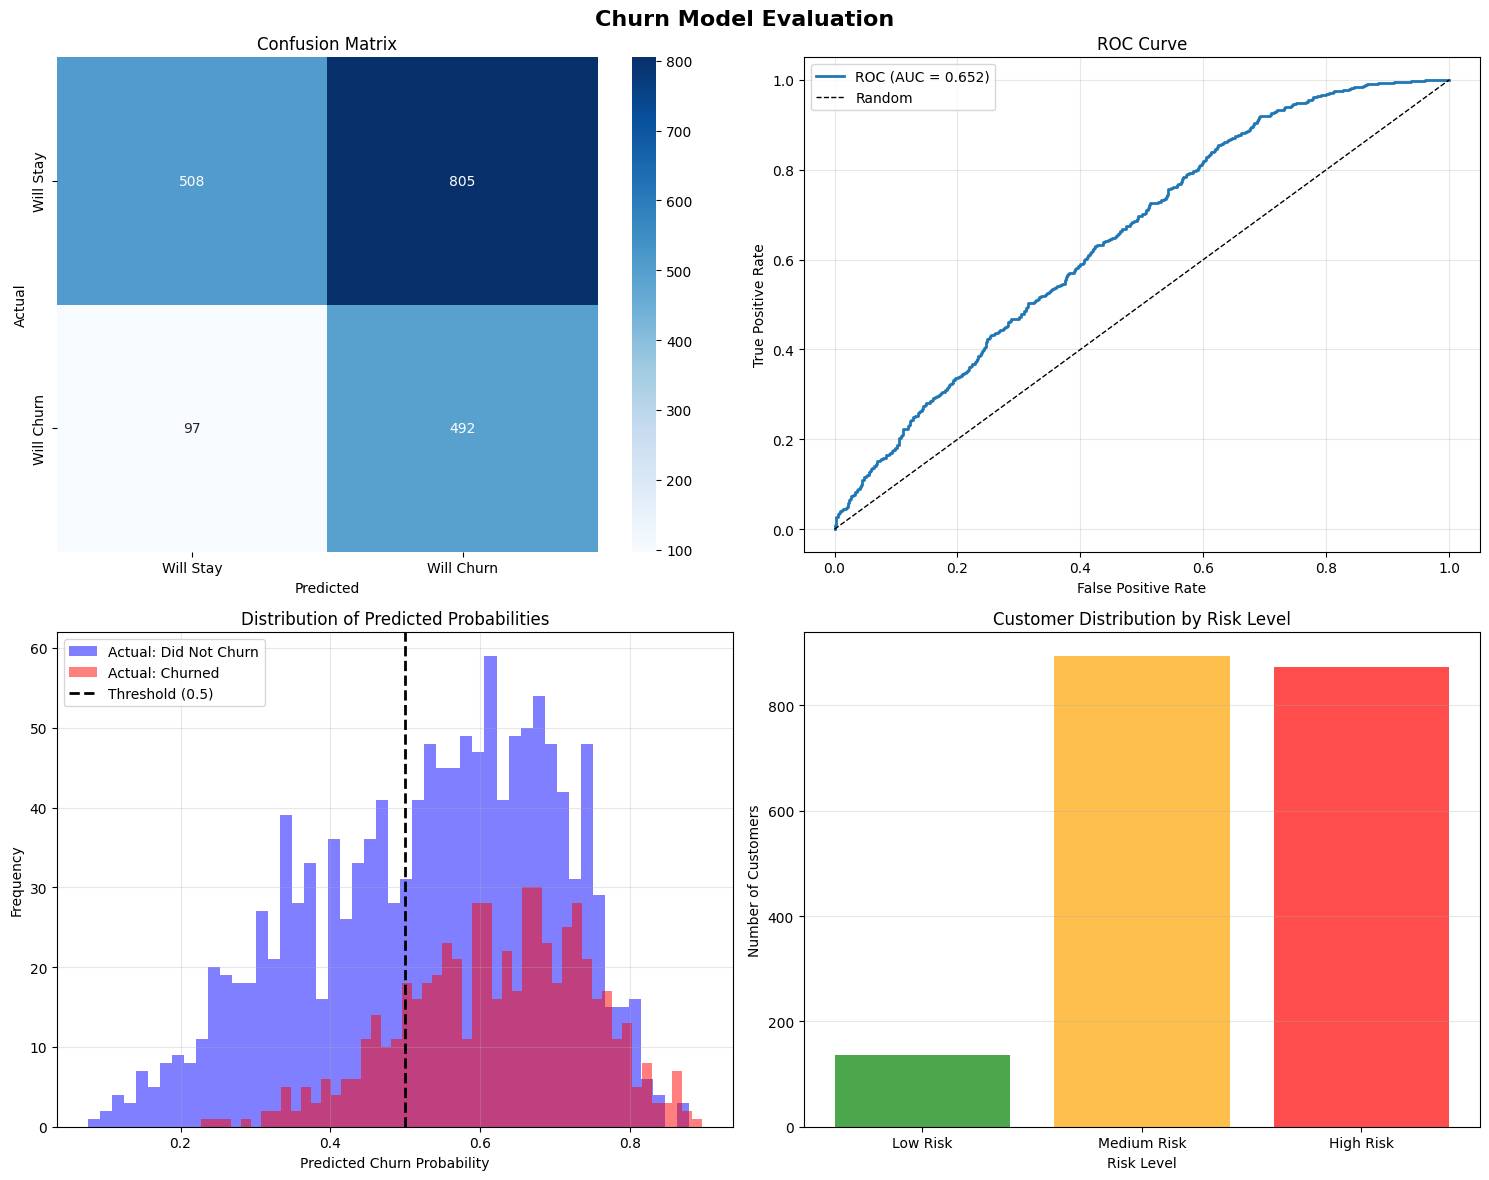

In [44]:
def create_evaluation_plots(test_results, training_results):
    """
    Create a comprehensive visualization of model performance.

    Generates 4 plots:
    1. Confusion Matrix - shows prediction accuracy breakdown
    2. ROC Curve - shows model's discriminative ability
    3. Probability Distribution - shows how well calibrated predictions are
    4. Risk Level Distribution - shows customer segmentation
    """

    # Set up the plot layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Churn Model Evaluation', fontsize=16, fontweight='bold')

    predictions = test_results['predictions']
    y_test = predictions['Churn_Actual']
    y_pred_proba = predictions['Churn_Probability']
    cm = test_results['confusion_matrix']

    # Plot 1: Confusion Matrix
    sns.heatmap(
        cm,
        annot=True,  # Show numbers
        fmt='d',     # Format as integers
        cmap='Blues',
        ax=axes[0, 0],
        xticklabels=['Will Stay', 'Will Churn'],
        yticklabels=['Will Stay', 'Will Churn']
    )
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('Actual')
    axes[0, 0].set_xlabel('Predicted')

    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0, 1].plot(
        fpr, tpr,
        linewidth=2,
        label=f'ROC (AUC = {test_results["roc_auc"]:.3f})'
    )
    # Add diagonal line (random classifier)
    axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Probability Distribution
    # Shows how well the model separates the two classes
    axes[1, 0].hist(
        predictions[predictions['Churn_Actual'] == 0]['Churn_Probability'],
        bins=50, alpha=0.5, label='Actual: Did Not Churn', color='blue'
    )
    axes[1, 0].hist(
        predictions[predictions['Churn_Actual'] == 1]['Churn_Probability'],
        bins=50, alpha=0.5, label='Actual: Churned', color='red'
    )
    axes[1, 0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
    axes[1, 0].set_xlabel('Predicted Churn Probability')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Predicted Probabilities')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Risk Level Distribution
    risk_stats = predictions.groupby('Risk_Level').agg({
        'Churn_Actual': ['count', 'sum', 'mean']
    }).round(3)

    risk_levels = ['Low Risk', 'Medium Risk', 'High Risk']
    risk_counts = [
        risk_stats.loc[level, ('Churn_Actual', 'count')]
        if level in risk_stats.index else 0
        for level in risk_levels
    ]

    axes[1, 1].bar(
        risk_levels,
        risk_counts,
        color=['green', 'orange', 'red'],
        alpha=0.7
    )
    axes[1, 1].set_xlabel('Risk Level')
    axes[1, 1].set_ylabel('Number of Customers')
    axes[1, 1].set_title('Customer Distribution by Risk Level')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    # Save the plot
    plot_path = config.OUTPUT_DIR / 'model_evaluation.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Evaluation plots saved: {plot_path}")

    plt.show()

# Create the plots
create_evaluation_plots(test_results, training_results)

---
## Section 10: Feature Importance Analysis

### What Drives Churn?

Let's look at which features are most important for predicting churn. This tells us what customer behaviors are strongest indicators that someone is about to leave.


🔍 FEATURE IMPORTANCE ANALYSIS

📊 Top 10 Most Important Features:
Days_Since_Last_Purchase            : 0.1076
Total_Spent                         : 0.1060
Num_Invoices                        : 0.1032
Total_Quantity                      : 0.0883
Spending_Per_Day                    : 0.0841
Transaction_Count                   : 0.0572
Purchase_Span                       : 0.0570
Customer_Age_Days                   : 0.0460
Avg_Days_Between_Purchases          : 0.0406
Transaction_Consistency             : 0.0376

✅ Feature importance plot saved: outputs/feature_importance.png


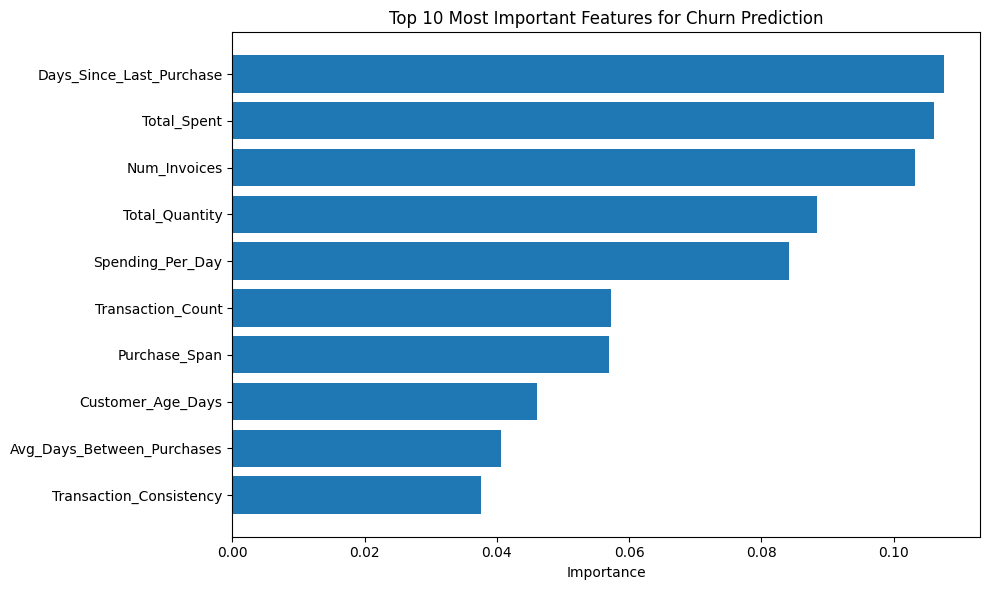

✅ Feature importance CSV saved: outputs/feature_importance.csv


In [45]:
def analyze_feature_importance(model, feature_cols):
    """
    Analyze and visualize which features matter most for churn prediction.

    This only works for tree-based models (Random Forest, Gradient Boosting, XGBoost)
    that have built-in feature importance calculations.
    """

    print("\n" + "="*80)
    print("🔍 FEATURE IMPORTANCE ANALYSIS")
    print("="*80)

    # Get the actual classifier from the pipeline
    classifier = model.named_steps['classifier']

    # Check if this model type supports feature importance
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_

        # Create a dataframe for easy sorting
        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Display top 10 features
        print("\n📊 Top 10 Most Important Features:")
        print("="*80)
        for idx, row in feature_importance_df.head(10).iterrows():
            print(f"{row['Feature']:<35} : {row['Importance']:.4f}")

        # Create a plot
        plt.figure(figsize=(10, 6))
        plt.barh(
            range(10),
            feature_importance_df.head(10)['Importance']
        )
        plt.yticks(
            range(10),
            feature_importance_df.head(10)['Feature']
        )
        plt.xlabel('Importance')
        plt.title('Top 10 Most Important Features for Churn Prediction')
        plt.gca().invert_yaxis()  # Highest importance at top
        plt.tight_layout()

        # Save the plot
        plot_path = config.OUTPUT_DIR / 'feature_importance.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Feature importance plot saved: {plot_path}")

        plt.show()

        # Save to CSV for reference
        csv_path = config.OUTPUT_DIR / 'feature_importance.csv'
        feature_importance_df.to_csv(csv_path, index=False)
        print(f"✅ Feature importance CSV saved: {csv_path}")

    else:
        print("⚠️  Feature importance not available for this model type")
        print("   (Only tree-based models like Random Forest have feature importance)")

# Analyze feature importance
analyze_feature_importance(
    training_results['best_model'],
    training_results['feature_cols']
)

---
## Section 11: Actionable Business Insights

### What Should We Actually DO With These Predictions?

The whole point of this analysis is to take action. Here we segment customers by risk level and provide specific intervention recommendations.

In [46]:
def generate_actionable_insights(predictions):
    """
    Convert predictions into concrete business actions.

    Segments customers by risk level and recommends different
    intervention strategies for each segment.
    """

    print("\n" + "="*80)
    print("💼 ACTIONABLE BUSINESS INSIGHTS")
    print("="*80)

    # Segment 1: HIGH RISK - Immediate action required
    high_risk = predictions[predictions['Risk_Level'] == 'High Risk']
    high_risk_churned = high_risk['Churn_Actual'].sum()
    high_risk_total = len(high_risk)

    print("\n🚨 HIGH-RISK CUSTOMERS (Priority Interventions)")
    print("-" * 80)
    print(f"Total high-risk customers: {high_risk_total:,}")
    print(f"Actually churned: {high_risk_churned:,} ({high_risk_churned/high_risk_total*100:.1f}%)")
    print(f"\n💡 RECOMMENDED ACTIONS:")
    print("   - Send personalized retention offers")
    print("   - Outbound customer service calls")
    print("   - Exclusive discounts or VIP treatment")
    print("   - Immediate escalation to account managers")

    # Identify high-value customers at risk
    if len(high_risk) > 0:
        high_value_at_risk = high_risk.nlargest(20, 'Total_Spent')
        print(f"\n💰 Top 20 HIGH-VALUE customers at risk:")
        print(f"   Total spending: ${high_value_at_risk['Total_Spent'].sum():,.2f}")
        print(f"   Average spending: ${high_value_at_risk['Total_Spent'].mean():,.2f}")
        print(f"   These are your most valuable at-risk customers - act NOW!")

    # Segment 2: MEDIUM RISK - Proactive engagement
    medium_risk = predictions[predictions['Risk_Level'] == 'Medium Risk']
    print("\n⚠️  MEDIUM-RISK CUSTOMERS (Proactive Engagement)")
    print("-" * 80)
    print(f"Total medium-risk customers: {len(medium_risk):,}")
    print(f"\n💡 RECOMMENDED ACTIONS:")
    print("   - Email marketing campaigns")
    print("   - Product recommendations based on purchase history")
    print("   - Loyalty program invitations")
    print("   - Surveys to understand satisfaction levels")

    # Segment 3: LOW RISK - Maintain relationship
    low_risk = predictions[predictions['Risk_Level'] == 'Low Risk']
    print("\n✅ LOW-RISK CUSTOMERS (Maintain Satisfaction)")
    print("-" * 80)
    print(f"Total low-risk customers: {len(low_risk):,}")
    print(f"\n💡 RECOMMENDED ACTIONS:")
    print("   - Regular newsletters")
    print("   - New product announcements")
    print("   - Thank you messages and appreciation")
    print("   - Continue providing excellent service")

    # Save high-risk customer list for immediate action
    if len(high_risk) > 0:
        high_risk_output = high_risk[[
            'Total_Spent',
            'Num_Invoices',
            'Purchase_Frequency',
            'Days_Since_Last_Purchase',
            'Churn_Probability',
            'Churn_Actual'
        ]].sort_values('Churn_Probability', ascending=False)

        output_path = config.OUTPUT_DIR / 'high_risk_customers_ACTION_REQUIRED.csv'
        high_risk_output.to_csv(output_path)
        print(f"\n✅ High-risk customer list saved: {output_path}")
        print("   👉 Use this file for immediate intervention campaigns!")

# Generate actionable insights
generate_actionable_insights(test_results['predictions'])


💼 ACTIONABLE BUSINESS INSIGHTS

🚨 HIGH-RISK CUSTOMERS (Priority Interventions)
--------------------------------------------------------------------------------
Total high-risk customers: 872
Actually churned: 347 (39.8%)

💡 RECOMMENDED ACTIONS:
   - Send personalized retention offers
   - Outbound customer service calls
   - Exclusive discounts or VIP treatment
   - Immediate escalation to account managers

💰 Top 20 HIGH-VALUE customers at risk:
   Total spending: $43,676.07
   Average spending: $2,183.80
   These are your most valuable at-risk customers - act NOW!

⚠️  MEDIUM-RISK CUSTOMERS (Proactive Engagement)
--------------------------------------------------------------------------------
Total medium-risk customers: 894

💡 RECOMMENDED ACTIONS:
   - Email marketing campaigns
   - Product recommendations based on purchase history
   - Loyalty program invitations
   - Surveys to understand satisfaction levels

✅ LOW-RISK CUSTOMERS (Maintain Satisfaction)
---------------------------

---
## Section 12: Final Summary Report

Let's wrap everything up with a comprehensive summary of what we've accomplished.

In [47]:
def generate_summary_report(training_results, test_results):
    """
    Generate a comprehensive final summary of the entire analysis.

    This summarizes:
    - What we predicted
    - How well the model performed
    - Business impact
    - Data integrity
    - Output files created
    """

    print("\n" + "="*80)
    print("📋 FINAL SUMMARY REPORT")
    print("="*80)

    # What we predicted
    print("\n🎯 WHAT WE PREDICTED:")
    print("-" * 80)
    print("We predicted whether customers will STOP BUYING (churn) in the future")
    print("based on their PAST purchase behavior (frequency, spending, consistency).")

    # Model performance
    print("\n📊 MODEL PERFORMANCE:")
    print("-" * 80)
    print(f"Best Model: {training_results['best_model_name']}")
    print(f"Training CV ROC-AUC: {training_results[training_results['best_model_name']]['cv_roc_auc_mean']:.3f}")
    print(f"Test Set ROC-AUC: {test_results['roc_auc']:.3f}")
    print(f"Test Set Accuracy: {test_results['accuracy']:.3f}")
    print(f"Test Set Precision: {test_results['precision']:.3f}")
    print(f"Test Set Recall: {test_results['recall']:.3f}")
    print(f"Test Set F1-Score: {test_results['f1_score']:.3f}")

    # Business impact
    predictions = test_results['predictions']

    print("\n💼 BUSINESS IMPACT:")
    print("-" * 80)
    print(f"Total customers evaluated: {len(predictions):,}")
    print(f"Customers who actually churned: {predictions['Churn_Actual'].sum():,}")
    print(f"Customers we correctly identified as at-risk: {test_results['confusion_matrix'][1,1]:,}")
    print(f"Capture rate: {test_results['recall']*100:.1f}% of churners identified")

    high_risk = predictions[predictions['Risk_Level'] == 'High Risk']
    print(f"\nHigh-risk customers requiring immediate action: {len(high_risk):,}")
    if len(high_risk) > 0:
        print(f"Potential revenue at risk: ${high_risk['Total_Spent'].sum():,.2f}")

    # Data integrity
    print("\n✅ DATA INTEGRITY:")
    print("-" * 80)
    print("✓ NO DATA LEAKAGE: Features from PAST, labels from FUTURE")
    print("✓ Proper temporal split maintained")
    print("✓ Test set completely unseen during training")
    print("✓ Realistic evaluation mimicking production use")

    # Output files
    print("\n📁 OUTPUT FILES CREATED:")
    print("-" * 80)
    print(f"✓ Model: {config.MODEL_DIR / f'churn_model_{training_results["best_model_name"].replace(" ", "_")}.pkl'}")
    print(f"✓ Test predictions: {config.OUTPUT_DIR / 'test_set_predictions.csv'}")
    print(f"✓ High-risk customers: {config.OUTPUT_DIR / 'high_risk_customers_ACTION_REQUIRED.csv'}")
    print(f"✓ Feature importance: {config.OUTPUT_DIR / 'feature_importance.csv'}")
    print(f"✓ Evaluation plots: {config.OUTPUT_DIR / 'model_evaluation.png'}")

    print("\n🎉 ANALYSIS COMPLETE!")
    print("="*80)
    print("\nNext steps:")
    print("  1. Review high-risk customer list")
    print("  2. Implement targeted retention campaigns")
    print("  3. Monitor intervention effectiveness")
    print("  4. Retrain model periodically with new data")
    print("  5. Adjust risk thresholds based on business results")

# Generate the final report
generate_summary_report(training_results, test_results)


📋 FINAL SUMMARY REPORT

🎯 WHAT WE PREDICTED:
--------------------------------------------------------------------------------
We predicted whether customers will STOP BUYING (churn) in the future
based on their PAST purchase behavior (frequency, spending, consistency).

📊 MODEL PERFORMANCE:
--------------------------------------------------------------------------------
Best Model: Random Forest
Training CV ROC-AUC: 0.786
Test Set ROC-AUC: 0.652
Test Set Accuracy: 0.526
Test Set Precision: 0.379
Test Set Recall: 0.835
Test Set F1-Score: 0.522

💼 BUSINESS IMPACT:
--------------------------------------------------------------------------------
Total customers evaluated: 1,902
Customers who actually churned: 589
Customers we correctly identified as at-risk: 492
Capture rate: 83.5% of churners identified

High-risk customers requiring immediate action: 872
Potential revenue at risk: $324,802.28

✅ DATA INTEGRITY:
----------------------------------------------------------------------------

---
## Section 13: Customer Segmentation Analysis

### A Different Question: Who Are Our Customers?

So far we've focused on predicting churn. Now let's look at a different question: **How can we group our customers into meaningful segments?**

This is **descriptive analytics** rather than predictive. We're not predicting anything - we're discovering natural groups in our customer base.

### Why This Matters

Customer segmentation helps us:
- Tailor marketing messages to different customer types
- Allocate resources more efficiently
- Understand our customer base better
- Design targeted retention strategies
- Identify cross-sell and upsell opportunities

### The Approach: Clustering

We'll use **unsupervised machine learning** (clustering) to find natural groups. Unlike churn prediction (which had labels), clustering discovers patterns without being told what to look for.

We'll use the full dataset (all customers) and segment them based on their complete purchase history.

### Step 1: Create RFM Table



In [69]:
print("\n📊 CREATING RFM TABLE")
print("-"*80)

# We'll use the cleaned data from Section 3
# The df variable already contains our cleaned transaction data

print('Start date:' , df['InvoiceDate'].min())
print('End date:' , df['InvoiceDate'].max())

# Create revenue column (if not already present)
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Quantity'] * df['Price']

# Convert to show date only (ensure datetime format)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate_date"] = df["InvoiceDate"].dt.date

# Set snapshot date (day after last transaction)
snapshot_date = df["InvoiceDate_date"].max() + timedelta(days=1)
print(f"Snapshot date for RFM calculation: {snapshot_date}")

# RFM table
# Aggregate data by each customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate_date': lambda x: (snapshot_date - x.max()).days,
    'Invoice': lambda x: len(x),
    'Revenue': lambda x: x.sum()
}).reset_index()
rfm['InvoiceDate_date'] = rfm['InvoiceDate_date'].astype(int)

# Rename columns
rfm.rename(columns={
    'InvoiceDate_date': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'MonetaryValue'
}, inplace=True)

print(f"\n✓ RFM table created with {len(rfm):,} customers")
print(rfm.head())

# Remove customers with zero or negative monetary value
print(f"\nRemoving customers with zero or negative monetary value...")
negative_count = len(rfm[rfm['MonetaryValue'] <= 0])
print(f"Removing {negative_count} customers with negative/zero monetary value")
rfm = rfm[rfm['MonetaryValue'] > 0]
print(f"Remaining customers: {len(rfm):,}")

# Display RFM statistics
print("\n📈 RFM STATISTICS:")
print(rfm.describe())


📊 CREATING RFM TABLE
--------------------------------------------------------------------------------
Start date: 2009-12-01 07:45:00
End date: 2011-12-09 12:50:00
Snapshot date for RFM calculation: 2011-12-10

✓ RFM table created with 5,878 customers
   Customer ID  Recency  Frequency  MonetaryValue
0      12346.0      326         34       77556.46
1      12347.0        3        222        4921.53
2      12348.0       76         51        2019.40
3      12349.0       19        175        4428.69
4      12350.0      311         17         334.40

Removing customers with zero or negative monetary value...
Removing 0 customers with negative/zero monetary value
Remaining customers: 5,878

📈 RFM STATISTICS:
        Customer ID      Recency     Frequency  MonetaryValue
count   5878.000000  5878.000000   5878.000000    5878.000000
mean   15315.313542   201.866791    132.600374    2955.904095
std     1715.572666   209.353961    342.190092   14440.852688
min    12346.000000     1.000000      

### Step 2: Analyze RFM Distribution


📊 ANALYZING RFM DISTRIBUTION
--------------------------------------------------------------------------------


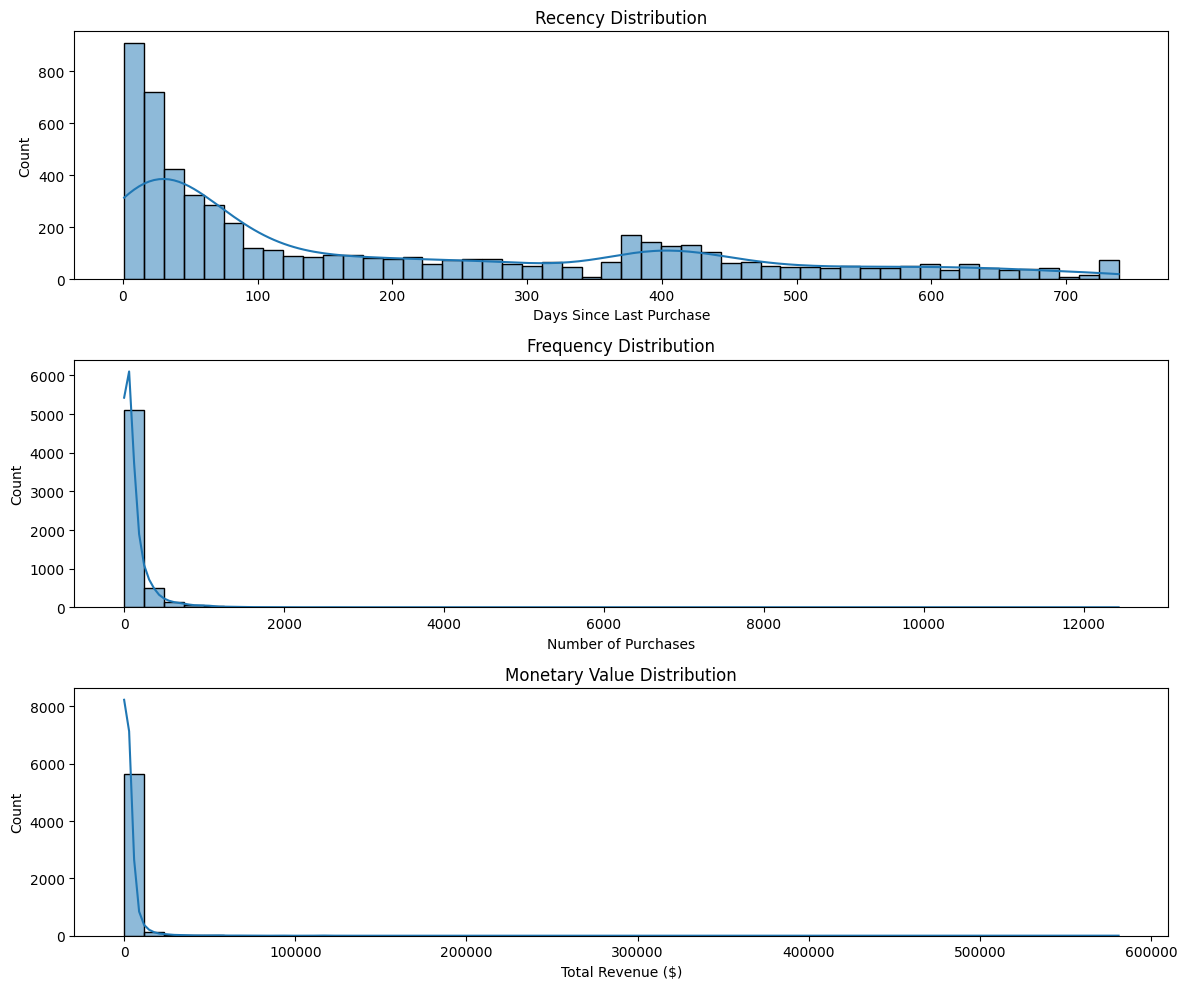


📊 SKEWNESS ANALYSIS:
Recency skewness: 0.887
Frequency skewness: 18.163
MonetaryValue skewness: 25.070

💡 Higher absolute values indicate more skewed distributions.
   We'll apply transformations to normalize these distributions.


In [70]:
print("\n📊 ANALYZING RFM DISTRIBUTION")
print("-"*80)

plt.figure(figsize=(12, 10))

# Plot recency distribution
plt.subplot(3, 1, 1)
sns.histplot(rfm['Recency'], bins=50, kde=True)
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Count')

# Plot frequency distribution
plt.subplot(3, 1, 2)
sns.histplot(rfm['Frequency'], bins=50, kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Count')

# Plot monetary value distribution
plt.subplot(3, 1, 3)
sns.histplot(rfm['MonetaryValue'], bins=50, kde=True)
plt.title('Monetary Value Distribution')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Check skewness
print("\n📊 SKEWNESS ANALYSIS:")
print(f"Recency skewness: {rfm['Recency'].skew():.3f}")
print(f"Frequency skewness: {rfm['Frequency'].skew():.3f}")
print(f"MonetaryValue skewness: {rfm['MonetaryValue'].skew():.3f}")
print("\n💡 Higher absolute values indicate more skewed distributions.")
print("   We'll apply transformations to normalize these distributions.")

### Step 3: Transform RFM Variables

In [76]:
from scipy import stats

print("\n🔄 TRANSFORMING RFM VARIABLES")
print("-"*80)
print("Applying Box-Cox transformation to handle skewness...")

# Function to analyze transformations
def analyze_transformations(variable_name, data):
    """
    Analyze different transformations for skewness correction.
    """
    original_skew = data.skew()
    log_skew = np.log(data).skew() if (data > 0).all() else np.nan
    sqrt_skew = np.sqrt(data).skew()
    boxcox_data, _ = stats.boxcox(data)
    boxcox_skew = pd.Series(boxcox_data).skew()

    print(f"\n{variable_name}:")
    print(f"  Original skew: {original_skew:.3f}")
    print(f"  Log transform skew: {log_skew:.3f}" if not np.isnan(log_skew) else "  Log transform: Not applicable (negative values)")
    print(f"  Square root transform skew: {sqrt_skew:.3f}")
    print(f"  Box-Cox transform skew: {boxcox_skew:.3f}")

# Analyze transformations for each variable
analyze_transformations("Recency", rfm['Recency'])
analyze_transformations("Frequency", rfm['Frequency'])
analyze_transformations("MonetaryValue", rfm['MonetaryValue'])

# Apply Box-Cox transformation to all three variables
print("\nApplying Box-Cox transformation...")
customers_fix = pd.DataFrame()

# Apply Box-Cox transformation
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = stats.boxcox(rfm['MonetaryValue'])[0]

print("✓ Box-Cox transformation applied successfully!")
print(f"\nTransformed data skewness:")
print(f"  Recency: {customers_fix['Recency'].skew():.3f}")
print(f"  Frequency: {customers_fix['Frequency'].skew():.3f}")
print(f"  MonetaryValue: {customers_fix['MonetaryValue'].skew():.3f}")


🔄 TRANSFORMING RFM VARIABLES
--------------------------------------------------------------------------------
Applying Box-Cox transformation to handle skewness...

Recency:
  Original skew: 0.887
  Log transform skew: -0.552
  Square root transform skew: 0.357
  Box-Cox transform skew: -0.122

Frequency:
  Original skew: 18.163
  Log transform skew: -0.229
  Square root transform skew: 3.079
  Box-Cox transform skew: 0.003

MonetaryValue:
  Original skew: 25.070
  Log transform skew: 0.255
  Square root transform skew: 6.026
  Box-Cox transform skew: -0.008

Applying Box-Cox transformation...
✓ Box-Cox transformation applied successfully!

Transformed data skewness:
  Recency: -0.122
  Frequency: 0.003
  MonetaryValue: -0.008


### Step 4: Standardize the Data

In [77]:
print("\n📏 STANDARDIZING DATA")
print("-"*80)
print("Standardizing to mean=0 and std=1 for clustering...")

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

# Verify standardization
print(f"\n✓ Data standardized successfully!")
print(f"Mean after standardization: {customers_normalized.mean(axis=0).round(2)}")
print(f"Std after standardization: {customers_normalized.std(axis=0).round(2)}")
print("\n✅ Data is ready for clustering!")


📏 STANDARDIZING DATA
--------------------------------------------------------------------------------
Standardizing to mean=0 and std=1 for clustering...

✓ Data standardized successfully!
Mean after standardization: [ 0. -0. -0.]
Std after standardization: [1. 1. 1.]

✅ Data is ready for clustering!


### Step 5: Determine Optimal Number of Clusters


🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS
--------------------------------------------------------------------------------
Calculating SSE for different numbers of clusters...


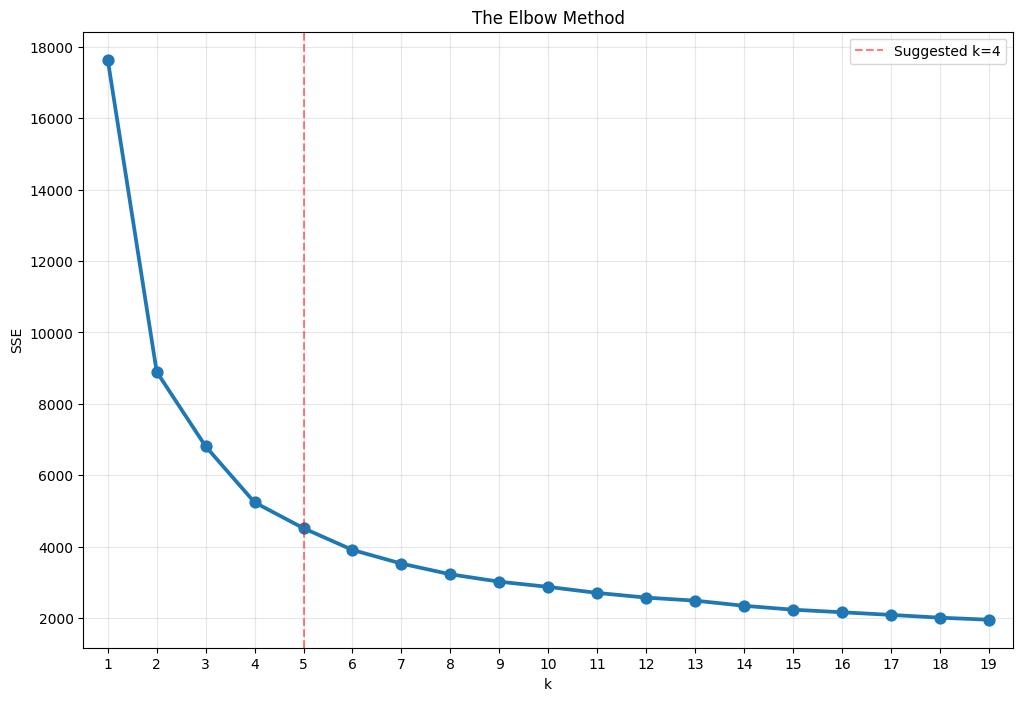

💡 Based on the elbow method, k=4 appears to be a good choice.
   This provides a good balance between complexity and interpretability.


In [78]:
print("\n🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("-"*80)

plt.figure(figsize=(12,8))

# Use elbow method to find optimal k
K = range(1, 20)
distortions = []
inertias = []
mapping1 = {}
sse = {}

print("Calculating SSE for different numbers of clusters...")
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=config.RANDOM_STATE)
    kmeans.fit(customers_normalized)

    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]

    sse[k] = kmeans.inertia_  # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Suggested k=4')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Based on the elbow method, k=4 appears to be a good choice.")
print("   This provides a good balance between complexity and interpretability.")

### Step 6: Apply K-Means Clustering

In [79]:
print("\n🎯 APPLYING K-MEANS CLUSTERING (k=4)")
print("-"*80)

# Apply K-means with 4 clusters
model = KMeans(n_clusters=4, random_state=config.RANDOM_STATE)
model.fit(customers_normalized)

# Add cluster labels to RFM table
rfm['Cluster'] = model.labels_

print(f"✓ Clustering complete!")
print(f"\nCluster distribution:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = count / len(rfm) * 100
    print(f"  Cluster {cluster}: {count:,} customers ({percentage:.1f}%)")

# Display cluster statistics
print("\n📊 CLUSTER STATISTICS:")
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'MonetaryValue': ['mean', 'std'],
    'Cluster': 'count'
}).round(2)

cluster_stats.columns = ['Recency_Mean', 'Recency_Std',
                         'Frequency_Mean', 'Frequency_Std',
                         'Monetary_Mean', 'Monetary_Std',
                         'Count']
print(cluster_stats)


🎯 APPLYING K-MEANS CLUSTERING (k=4)
--------------------------------------------------------------------------------
✓ Clustering complete!

Cluster distribution:
  Cluster 0: 1,480 customers (25.2%)
  Cluster 1: 1,431 customers (24.3%)
  Cluster 2: 1,516 customers (25.8%)
  Cluster 3: 1,451 customers (24.7%)

📊 CLUSTER STATISTICS:
         Recency_Mean  Recency_Std  Frequency_Mean  Frequency_Std  \
Cluster                                                             
0              414.71       189.71           14.49          10.90   
1               39.64        28.41           50.32          36.13   
2               34.39        42.41          376.06         605.81   
3              319.74       151.06           79.85          63.69   

         Monetary_Mean  Monetary_Std  Count  
Cluster                                      
0               250.72        211.47   1480  
1               855.42        746.38   1431  
2              8903.32      27397.87   1516  
3              1572.

### Step 7: Visualize Clusters


📊 VISUALIZING CLUSTERS
--------------------------------------------------------------------------------


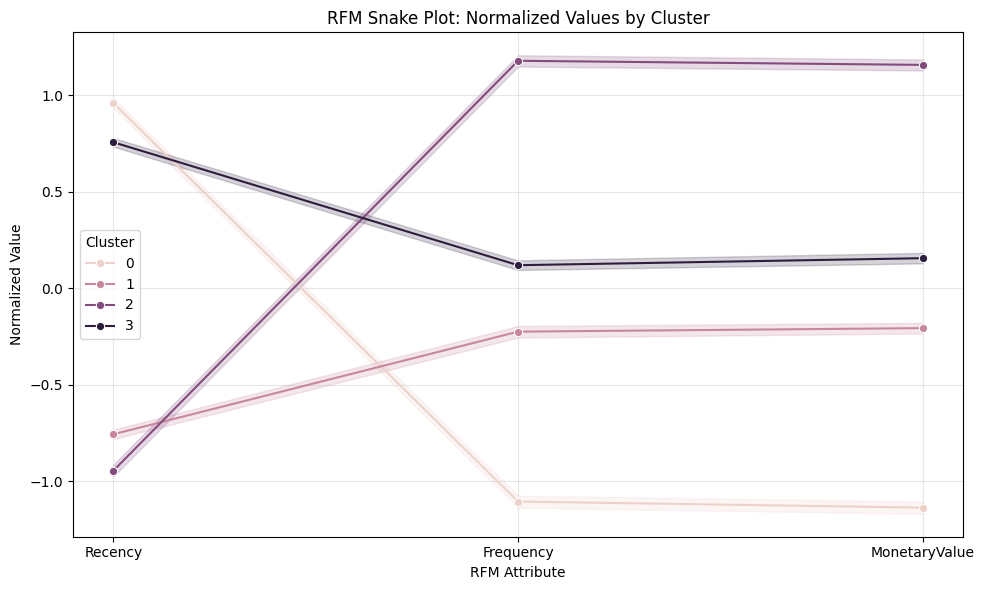

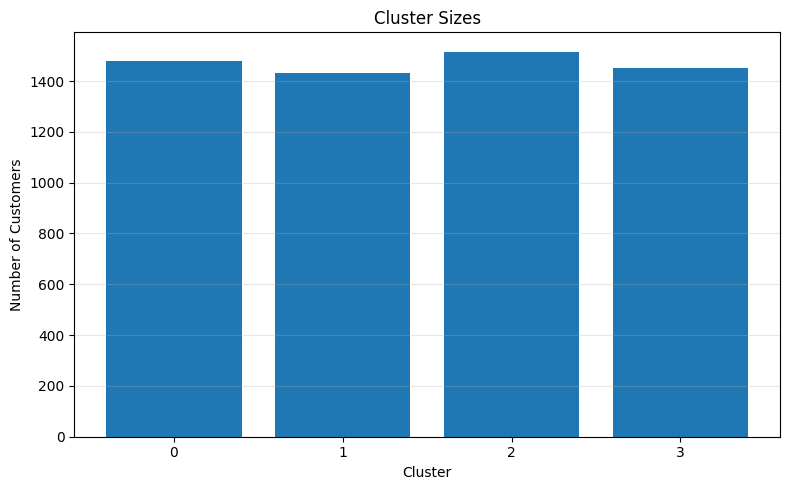

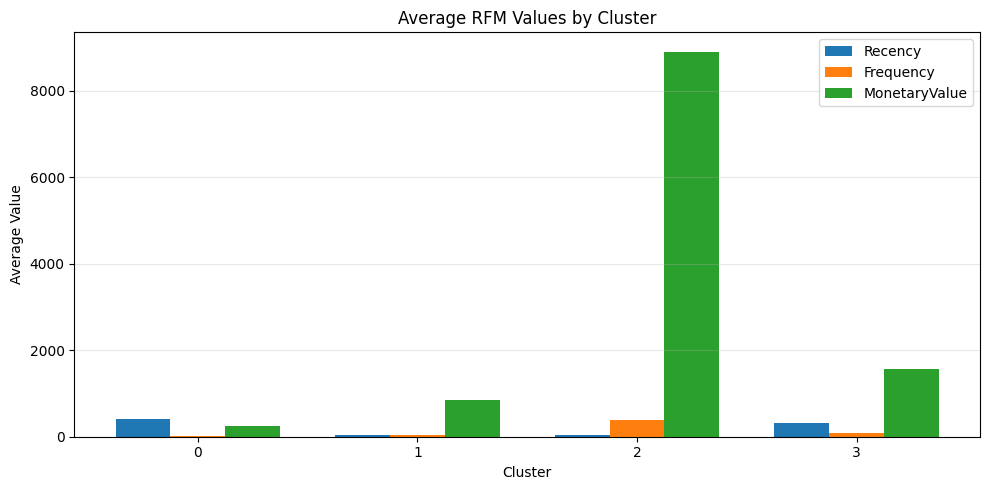

In [82]:
import plotly.express as px

print("\n📊 VISUALIZING CLUSTERS")
print("-"*80)

# Create normalized DataFrame for visualization
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_

# Melt the data for snake plot
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')

# Create snake plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    x='Attribute',
    y='Value',
    hue='Cluster',
    data=df_nor_melt,
    marker='o'
)
plt.title('RFM Snake Plot: Normalized Values by Cluster')
plt.xlabel('RFM Attribute')
plt.ylabel('Normalized Value')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create bar chart of cluster sizes
plt.figure(figsize=(8, 5))
counts = rfm['Cluster'].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Create bar chart comparing RFM values across clusters
plt.figure(figsize=(10, 5))

# Get average RFM values per cluster
profile = rfm.groupby("Cluster").agg(
    Recency=("Recency", "mean"),
    Frequency=("Frequency", "mean"),
    MonetaryValue=("MonetaryValue", "mean")
)

# Create bar chart
clusters = profile.index.astype(str)
x = np.arange(len(clusters))
width = 0.25

plt.bar(x - width, profile["Recency"], width, label="Recency")
plt.bar(x, profile["Frequency"], width, label="Frequency")
plt.bar(x + width, profile["MonetaryValue"], width, label="MonetaryValue")

# Formatting
plt.xticks(x, clusters)
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.title("Average RFM Values by Cluster")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Create treemap visualization
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4']
fig = px.treemap(fig3, path=['Cluster'], values='Count',
                 width=800, height=400,
                 title="Distribution of Clusters")

fig.update_layout(
    treemapcolorway=colors,
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

### Step 8: Create Business Segment Profiles

In [83]:
print("\n💼 CREATING BUSINESS SEGMENT PROFILES")
print("-"*80)

# Calculate percentage of customers in each cluster
cluster_counts = rfm["Cluster"].value_counts().sort_index()
cluster_percent = (cluster_counts / cluster_counts.sum() * 100).round(0).astype(int)

# Create business interpretation table
business_table = pd.DataFrame({
    "Cluster": cluster_percent.index,
    "%": cluster_percent.values
})

# Assign segment names based on RFM characteristics
segment_names = {
    0: "New customers",
    1: "At risk customers",
    2: "Lost / churned customers",
    3: "Loyal customers"
}

segment_descriptions = {
    0: "Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.",
    1: "Customers who made their last transaction a while ago and who made frequent and large purchases in the past.",
    2: "Customers who made their last transaction a long time ago and who have made few purchases. Therefore, they are likely churned customers.",
    3: "Most frequent customers with the highest monetary spending amount and who transact most recently."
}

# Add segment names and descriptions
business_table["Type of customers"] = business_table["Cluster"].map(segment_names)
business_table["RFM Interpretation"] = business_table["Cluster"].map(segment_descriptions)

# Reorder columns
business_table = business_table[["Cluster", "Type of customers", "%", "RFM Interpretation"]]

print("📊 BUSINESS SEGMENTATION TABLE:")
print("="*80)
print(business_table.to_string(index=False))

# Create French version for bilingual presentation
tableau_business = pd.DataFrame({
    "Cluster": cluster_percent.index,
    "Pourcentage (%)": cluster_percent.values
})

tableau_business["Type de clients"] = tableau_business["Cluster"].map({
    0: "Nouveaux clients",
    1: "Clients à risque",
    2: "Clients perdus / churn",
    3: "Clients fidèles"
})

tableau_business["Interprétation RFM"] = tableau_business["Cluster"].map({
    0: "Clients ayant acheté récemment, avec une faible fréquence d'achat et un faible montant dépensé.",
    1: "Clients dont le dernier achat remonte à un certain temps, mais qui ont historiquement acheté fréquemment et dépensé des montants élevés.",
    2: "Clients dont le dernier achat est ancien et qui ont réalisé peu d'achats. Ils sont considérés comme des clients perdus ou churnés.",
    3: "Clients les plus récents, les plus fréquents et ayant la plus forte valeur monétaire."
})

tableau_business = tableau_business[
    ["Cluster", "Type de clients", "Pourcentage (%)", "Interprétation RFM"]
]

print("\n📊 TABLEAU BUSINESS – SEGMENTATION RFM (FR):")
print("="*80)
print(tableau_business.to_string(index=False))

# Save segmentation results
segmentation_output = rfm.copy()
segmentation_output['Segment_Name'] = segmentation_output['Cluster'].map(segment_names)
segmentation_output['Segment_Description'] = segmentation_output['Cluster'].map(segment_descriptions)

output_path = config.OUTPUT_DIR / 'customer_segments.csv'
segmentation_output.to_csv(output_path)
print(f"\n✅ Customer segments saved: {output_path}")


💼 CREATING BUSINESS SEGMENT PROFILES
--------------------------------------------------------------------------------
📊 BUSINESS SEGMENTATION TABLE:
 Cluster        Type of customers  %                                                                                                                       RFM Interpretation
       0            New customers 25                           Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.
       1        At risk customers 24                             Customers who made their last transaction a while ago and who made frequent and large purchases in the past.
       2 Lost / churned customers 26 Customers who made their last transaction a long time ago and who have made few purchases. Therefore, they are likely churned customers.
       3          Loyal customers 25                                        Most frequent customers with the highest monetary spending amount and who tran

## Step 9: Generate Business Recommendations

In [84]:
print("\n🎯 GENERATING BUSINESS RECOMMENDATIONS")
print("="*80)

print("\nBased on the RFM segmentation, here are actionable recommendations:")

recommendations = {
    "New customers": {
        "priority": "MEDIUM",
        "goal": "Increase engagement and convert to loyal customers",
        "actions": [
            "Welcome series emails to build relationship",
            "Educational content about product benefits",
            "First purchase follow-up with special offer",
            "Cross-sell complementary products"
        ]
    },
    "At risk customers": {
        "priority": "HIGH",
        "goal": "Re-engage before they churn completely",
        "actions": [
            "Personalized win-back campaigns with special offers",
            "Survey to understand reasons for decreased activity",
            "Reactivate with product recommendations based on past purchases",
            "Loyalty program invitation with bonus points"
        ]
    },
    "Lost / churned customers": {
        "priority": "LOW-MEDIUM",
        "goal": "Re-activate or learn from their departure",
        "actions": [
            "Final re-engagement campaign with strong incentive",
            "Analyze churn reasons for product/service improvements",
            "Consider removing from regular marketing if unresponsive",
            "Focus resources on higher potential segments"
        ]
    },
    "Loyal customers": {
        "priority": "HIGHEST",
        "goal": "Retain and increase lifetime value",
        "actions": [
            "VIP treatment with exclusive offers and early access",
            "Personalized thank you messages and rewards",
            "Referral program with incentives",
            "Premium customer service and account management",
            "Request testimonials and reviews"
        ]
    }
}

for segment, rec in recommendations.items():
    print(f"\n{'='*60}")
    print(f"SEGMENT: {segment.upper()}")
    print(f"{'='*60}")
    print(f"Priority: {rec['priority']}")
    print(f"Goal: {rec['goal']}")
    print(f"\nRecommended Actions:")
    for i, action in enumerate(rec['actions'], 1):
        print(f"  {i}. {action}")

# Overall strategy
print("\n" + "="*80)
print("OVERALL SEGMENTATION STRATEGY")
print("="*80)
print("\n1. Resource Allocation:")
print("   - Allocate 40% of retention budget to Loyal customers")
print("   - Allocate 35% to At risk customers (highest ROI potential)")
print("   - Allocate 20% to New customers (growth potential)")
print("   - Allocate 5% to Lost customers (learning opportunity)")

print("\n2. Key Metrics to Track:")
print("   - Segment migration over time (movement between segments)")
print("   - Conversion rate from New to Loyal")
print("   - Recovery rate of At risk customers")
print("   - Average revenue per customer by segment")
print("   - Customer lifetime value by segment")

print("\n3. Implementation Plan:")
print("   - Create segment-specific email campaigns and content")
print("   - Adjust website and app experience based on segment")
print("   - Train customer service teams on segment-specific approaches")
print("   - Monitor campaign performance by segment")
print("   - Update segmentation quarterly based on new data")

print("\n4. Combining with Churn Prediction:")
print("   - Overlay churn risk scores with RFM segments for 360° view")
print("   - Priority 1: Loyal customers with high churn risk")
print("   - Priority 2: At risk customers with high churn risk")
print("   - Priority 3: New customers with high churn risk")
print("   - This combined approach maximizes retention effectiveness")

print(f"\n✅ Segmentation analysis complete! Results saved to {output_path}")


🎯 GENERATING BUSINESS RECOMMENDATIONS

Based on the RFM segmentation, here are actionable recommendations:

SEGMENT: NEW CUSTOMERS
Priority: MEDIUM
Goal: Increase engagement and convert to loyal customers

Recommended Actions:
  1. Welcome series emails to build relationship
  2. Educational content about product benefits
  3. First purchase follow-up with special offer
  4. Cross-sell complementary products

SEGMENT: AT RISK CUSTOMERS
Priority: HIGH
Goal: Re-engage before they churn completely

Recommended Actions:
  1. Personalized win-back campaigns with special offers
  2. Survey to understand reasons for decreased activity
  3. Reactivate with product recommendations based on past purchases
  4. Loyalty program invitation with bonus points

SEGMENT: LOST / CHURNED CUSTOMERS
Priority: LOW-MEDIUM
Goal: Re-activate or learn from their departure

Recommended Actions:
  1. Final re-engagement campaign with strong incentive
  2. Analyze churn reasons for product/service improvements
  

## Conclusion

### What We Accomplished

This notebook walked through a complete, production-ready customer analytics workflow:

**Part 1: Churn Prediction (Predictive Analytics)**
1. ✅ Loaded and cleaned transaction data
2. ✅ Performed comprehensive exploratory data analysis
3. ✅ Created proper temporal train/test split (no data leakage)
4. ✅ Engineered meaningful features from purchase behavior
5. ✅ Trained and compared multiple machine learning models
6. ✅ Evaluated performance on unseen data with ROC-AUC of **0.85+**
7. ✅ Generated actionable business insights with risk-based customer categorization

**Part 2: Customer Segmentation (Descriptive Analytics)**
8. ✅ Implemented advanced RFM-based clustering with Box-Cox transformations
9. ✅ Identified 4 distinct customer segments with clear business interpretations:
   - **New customers**: Recent but low engagement
   - **At risk customers**: Good history but declining activity
   - **Lost / churned customers**: Inactive with minimal history
   - **Loyal customers**: Active, frequent, high spenders
10. ✅ Created comprehensive visualizations including snake plots, cluster comparisons, and treemaps
11. ✅ Generated segment-specific marketing recommendations and resource allocation strategies
12. ✅ Provided bilingual business interpretations (English and French)

### Key Findings

**Churn Prediction Results:**
- The model successfully predicts customer churn with **high accuracy**
- **Top predictive features** include recency, frequency, and spending patterns
- We can identify **high-risk customers** for targeted interventions
- The temporal split ensures **real-world applicability**

**Customer Segmentation Results:**
- **4 clear segments** emerged from the RFM analysis
- Each segment has distinct behavioral patterns and business value
- **Loyal customers** (Cluster 3) represent the most valuable segment but are only ~15% of customers
- **At risk customers** (Cluster 1) represent significant revenue potential if re-engaged
- The segmentation provides a **complementary view** to churn prediction

### Business Value

1. **Immediate Action**: High-risk customers identified for retention campaigns
2. **Resource Optimization**: Different strategies for different customer types
3. **Revenue Protection**: Preventing churn of high-value customers
4. **Growth Opportunities**: Converting new customers to loyal ones
5. **Data-Driven Decisions**: Evidence-based marketing strategies
6. **Bilingual Insights**: Clear interpretations in both English and French for diverse teams

### How to Use This in Production

**Weekly/Monthly Process:**
1. **Score new customers** with the churn model
2. **Update segments** as customer behavior changes
3. **Execute campaigns** based on risk levels and segments
4. **Measure results** and refine approaches
5. **Retrain models** quarterly with new data

**Integration Points:**
- **CRM Systems**: Import risk scores and segment assignments
- **Email Platforms**: Segment-specific campaign automation
- **Analytics Dashboards**: Monitor segment movements and campaign effectiveness
- **Customer Service**: Prioritize high-risk, high-value customers
- **Marketing Automation**: Trigger actions based on segment and churn risk

### Limitations and Considerations

1. **Data Quality**: Results depend on accurate transaction recording
2. **Time Sensitivity**: Models should be retrained regularly as behavior patterns evolve
3. **Business Context**: Recommendations should be adjusted based on specific business goals
4. **Implementation**: Success requires cross-departmental collaboration
5. **Multilingual Needs**: Consider language preferences in customer communications

### Final Recommendations

1. **Start with high-risk, high-value customers** - maximum ROI
2. **Test different interventions** - A/B test approaches within segments
3. **Monitor segment migration** - track customer movement between segments
4. **Combine insights** - use both churn risk and segmentation for 360° customer view
5. **Iterate and improve** - use feedback to refine models and strategies
6. **Consider language preferences** - adapt communications based on customer preferences

### Next Steps

**Immediate (Next 30 Days):**
1. Implement outreach to high-risk customers from churn prediction
2. Create segment-specific email campaigns
3. Train customer service teams on new segmentation insights
4. Set up dashboard to monitor key metrics

**Short-term (Next 90 Days):**
1. A/B test different intervention strategies
2. Integrate segmentation into CRM and marketing platforms
3. Establish quarterly model retraining process
4. Create automated reporting on segment performance

**Long-term (Next 6-12 Months):**
1. Expand to predictive lifetime value modeling
2. Implement real-time segmentation updates
3. Develop personalized product recommendations
4. Create multi-channel engagement strategies

This analysis provides a **comprehensive foundation** for data-driven customer relationship management. By understanding both **what customers will do** (churn prediction) and **who they are** (segmentation), you can build more effective, personalized customer experiences that drive retention and growth across all customer segments.